In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

# Raw data

In [2]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)
data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
data.shape
data.head(2)

SampleID SampleID_1 Child_ID Sample_type   Day Time MotherID  WMS  \
ID                                                                         
C11_10    11_10       D_10       11           C  25.0  T10    M11_M    0   
C11_11    11_11       D_11       11           C  29.0  T11    M11_M    0   

        Gender Mode of delivery  ...  Day of the last sample  \
ID                               ...                           
C11_10  Female        C-section  ...                   352.0   
C11_11  Female        C-section  ...                   352.0   

        Number of samples  Day of introducing solid food  \
ID                                                         
C11_10               25.0                          176.0   
C11_11               25.0                          176.0   

        Day of breastfeeding cessation  Solid food  Breastfeeding  \
ID                                                                  
C11_10                           356.0         0.0            1.0   
C11_11                           356.0         0.0            1.0   

        Feeding mode(BFD:0,MFD:1)  Sibling(Y:1,N:0)  PAE(Y:1,N:0)  \
ID                                                                  
C11_10                        0.0               0.0           0.0   
C11_11                        0.0               0.0           0.0   

        Allergy(Y:1,N:0)  
ID                        
C11_10               1.0  
C11_11               1.0  

[2 rows x 21 columns]

(10066, 466)

C11_10  C1_11  C1_12  C1_13  C1_14  C1_15  \
#OTU ID                                                                       
3303dcf065483fbf1a02ff00a59b7848       0      0     39     55     43      0   
44c9f59231dd703269388032da1d5a98       0      0     59     42      0     25   

                                  C1_16  C1_2  C1_21  C1_22  ...  M21_M  \
#OTU ID                                                      ...          
3303dcf065483fbf1a02ff00a59b7848    206   923    883    147  ...      0   
44c9f59231dd703269388032da1d5a98    185   969    773    111  ...      0   

                                  M25_M  M26_M  M28_M  M29_M  M31_M  M32_M  \
#OTU ID                                                                      
3303dcf065483fbf1a02ff00a59b7848      0      0      0      0      0     78   
44c9f59231dd703269388032da1d5a98      0      0      0      0      0      0   

                                  M34_M  M35_M  M4_M  
#OTU ID                                               
3303dcf065483fbf1a02ff00a59b7848      0      0     0  
44c9f59231dd703269388032da1d5a98      0      0     0  

[2 rows x 466 columns]

# 1. Alpha diversity

In [3]:
alpha_diversitys = pd.read_csv('../Results/1.2. Alpha_diversitys.csv', index_col=0)
alpha_diversitys['Time'] = meta.loc[alpha_diversitys.index, 'Time']
alpha_diversitys['log_Faith_PD'] = np.log10(alpha_diversitys['Faith_PD'])
alpha_diversitys['Gender'] = meta.loc[alpha_diversitys.index, 'Gender']
alpha_diversitys['DeliveryMode'] = meta.loc[alpha_diversitys.index, 'Mode of delivery']
alpha_diversitys['Sibling'] = meta.loc[alpha_diversitys.index, 'Sibling(Y:1,N:0)']
alpha_diversitys['SolidFood'] = meta.loc[alpha_diversitys.index, 'Solid food']
alpha_diversitys['BreastFeeding'] = meta.loc[alpha_diversitys.index, 'Breastfeeding']
alpha_diversitys['FeedingMode'] = meta.loc[alpha_diversitys.index, 'Feeding mode(BFD:0,MFD:1)']
alpha_diversitys['PAE'] = meta.loc[alpha_diversitys.index, 'PAE(Y:1,N:0)']
alpha_diversitys['Allergy'] = meta.loc[alpha_diversitys.index, 'Allergy(Y:1,N:0)']
alpha_diversitys.head(2)

Chao1   Shannon   Simpson  Observed  Dominance  Faith_PD Time  \
C11_10   91.0  5.801668  0.976246      91.0   0.023754  2.660819  T10   
C1_11   212.6  6.787125  0.987023     209.0   0.012977  5.306382  T11   

        log_Faith_PD  Gender DeliveryMode  Sibling  SolidFood  BreastFeeding  \
C11_10      0.425015  Female    C-section      0.0        0.0            1.0   
C1_11       0.724798    Male      Vaginal      0.0        0.0            1.0   

        FeedingMode  PAE  Allergy  
C11_10          0.0  0.0      1.0  
C1_11           1.0  1.0      1.0

In [4]:
def get_alpha_corr(index, alpha, envs):
    results = []
    for e in envs:
        xy = index[[alpha, e]]
        xy = xy.dropna()
        r = spearmanr(xy[alpha], xy[e])[0]
        p = 1
        elist = xy[e].values
        for i in range(999):
            np.random.shuffle(elist)
            rr = spearmanr(xy[alpha], elist)[0]
            if (r>0 and rr>=r) or (r<0 and rr<=r):
                p += 1
        p = p/1000.
        results.append([alpha, e, xy.shape[0], r, p])
    results = pd.DataFrame(results, columns=['Alpha', 'Env', 'N', 'R', 'pval'])
    return results

childs = [i for i in alpha_diversitys.index if i[0]=='C']
temp = alpha_diversitys.loc[childs, :]
temp['Time'] = [int(i[1:]) for i in meta.loc[temp.index, 'Time']]
res = get_alpha_corr(temp, 'Faith_PD', ['Time', 'Gender', 'DeliveryMode', 'SolidFood', 'BreastFeeding', 
                                        'FeedingMode', 'Sibling', 'PAE', 'Allergy'])
res.to_csv('../Results_0609/3.1. Alpha_Faith_PD_临床因素关联分析.csv')
res

Alpha            Env    N         R   pval
0  Faith_PD           Time  450  0.297686  0.001
1  Faith_PD         Gender  450 -0.228480  0.001
2  Faith_PD   DeliveryMode  450  0.016762  0.364
3  Faith_PD      SolidFood  450  0.318196  0.001
4  Faith_PD  BreastFeeding  450 -0.212938  0.001
5  Faith_PD    FeedingMode  445  0.120820  0.004
6  Faith_PD        Sibling  430  0.142004  0.002
7  Faith_PD            PAE  450  0.083280  0.029
8  Faith_PD        Allergy  450 -0.119566  0.004

In [5]:
import statsmodels.formula.api as smf
reg = smf.ols('Faith_PD ~ Time + Gender + DeliveryMode + SolidFood + BreastFeeding + FeedingMode + Sibling + PAE + Allergy', temp)
results = reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Faith_PD   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     4.546
Date:                Mon, 27 Jun 2022   Prob (F-statistic):           9.96e-06
Time:                        01:21:29   Log-Likelihood:                -1430.4
No. Observations:                 427   AIC:                             2881.
Df Residuals:                     417   BIC:                             2921.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.7761      2.395      2.829      0.005       2.068      11.485
Gender[T.Male]             -2.3541      0.843     -2.791      0.005      -4.012      -0.696
DeliveryMode[T.Vaginal]    -1.1908      0.752     -1.583      0.114      -2.670       0.288
Time                       -0.1207      0.059     -2.045      0.041      -0.237      -0.005
SolidFood                   2.0082      1.291      1.555      0.121      -0.530       4.546
BreastFeeding              -0.6459      1.899     -0.340      0.734      -4.378       3.087
FeedingMode                 1.0812      0.794      1.361      0.174      -0.480       2.643
Sibling                     2.6871      0.760      3.534      0.000       1.192       4.182
PAE                         1.2532      0.799      1.569      0.117      -0.317       2.823
Allergy                     1.6078      0.911      1.765      0.078      -0.183       3.399
==============================================================================
Omnibus:                      365.470   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7136.731
Skew:                           3.688   Prob(JB):                         0.00
Kurtosis:                      21.620   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

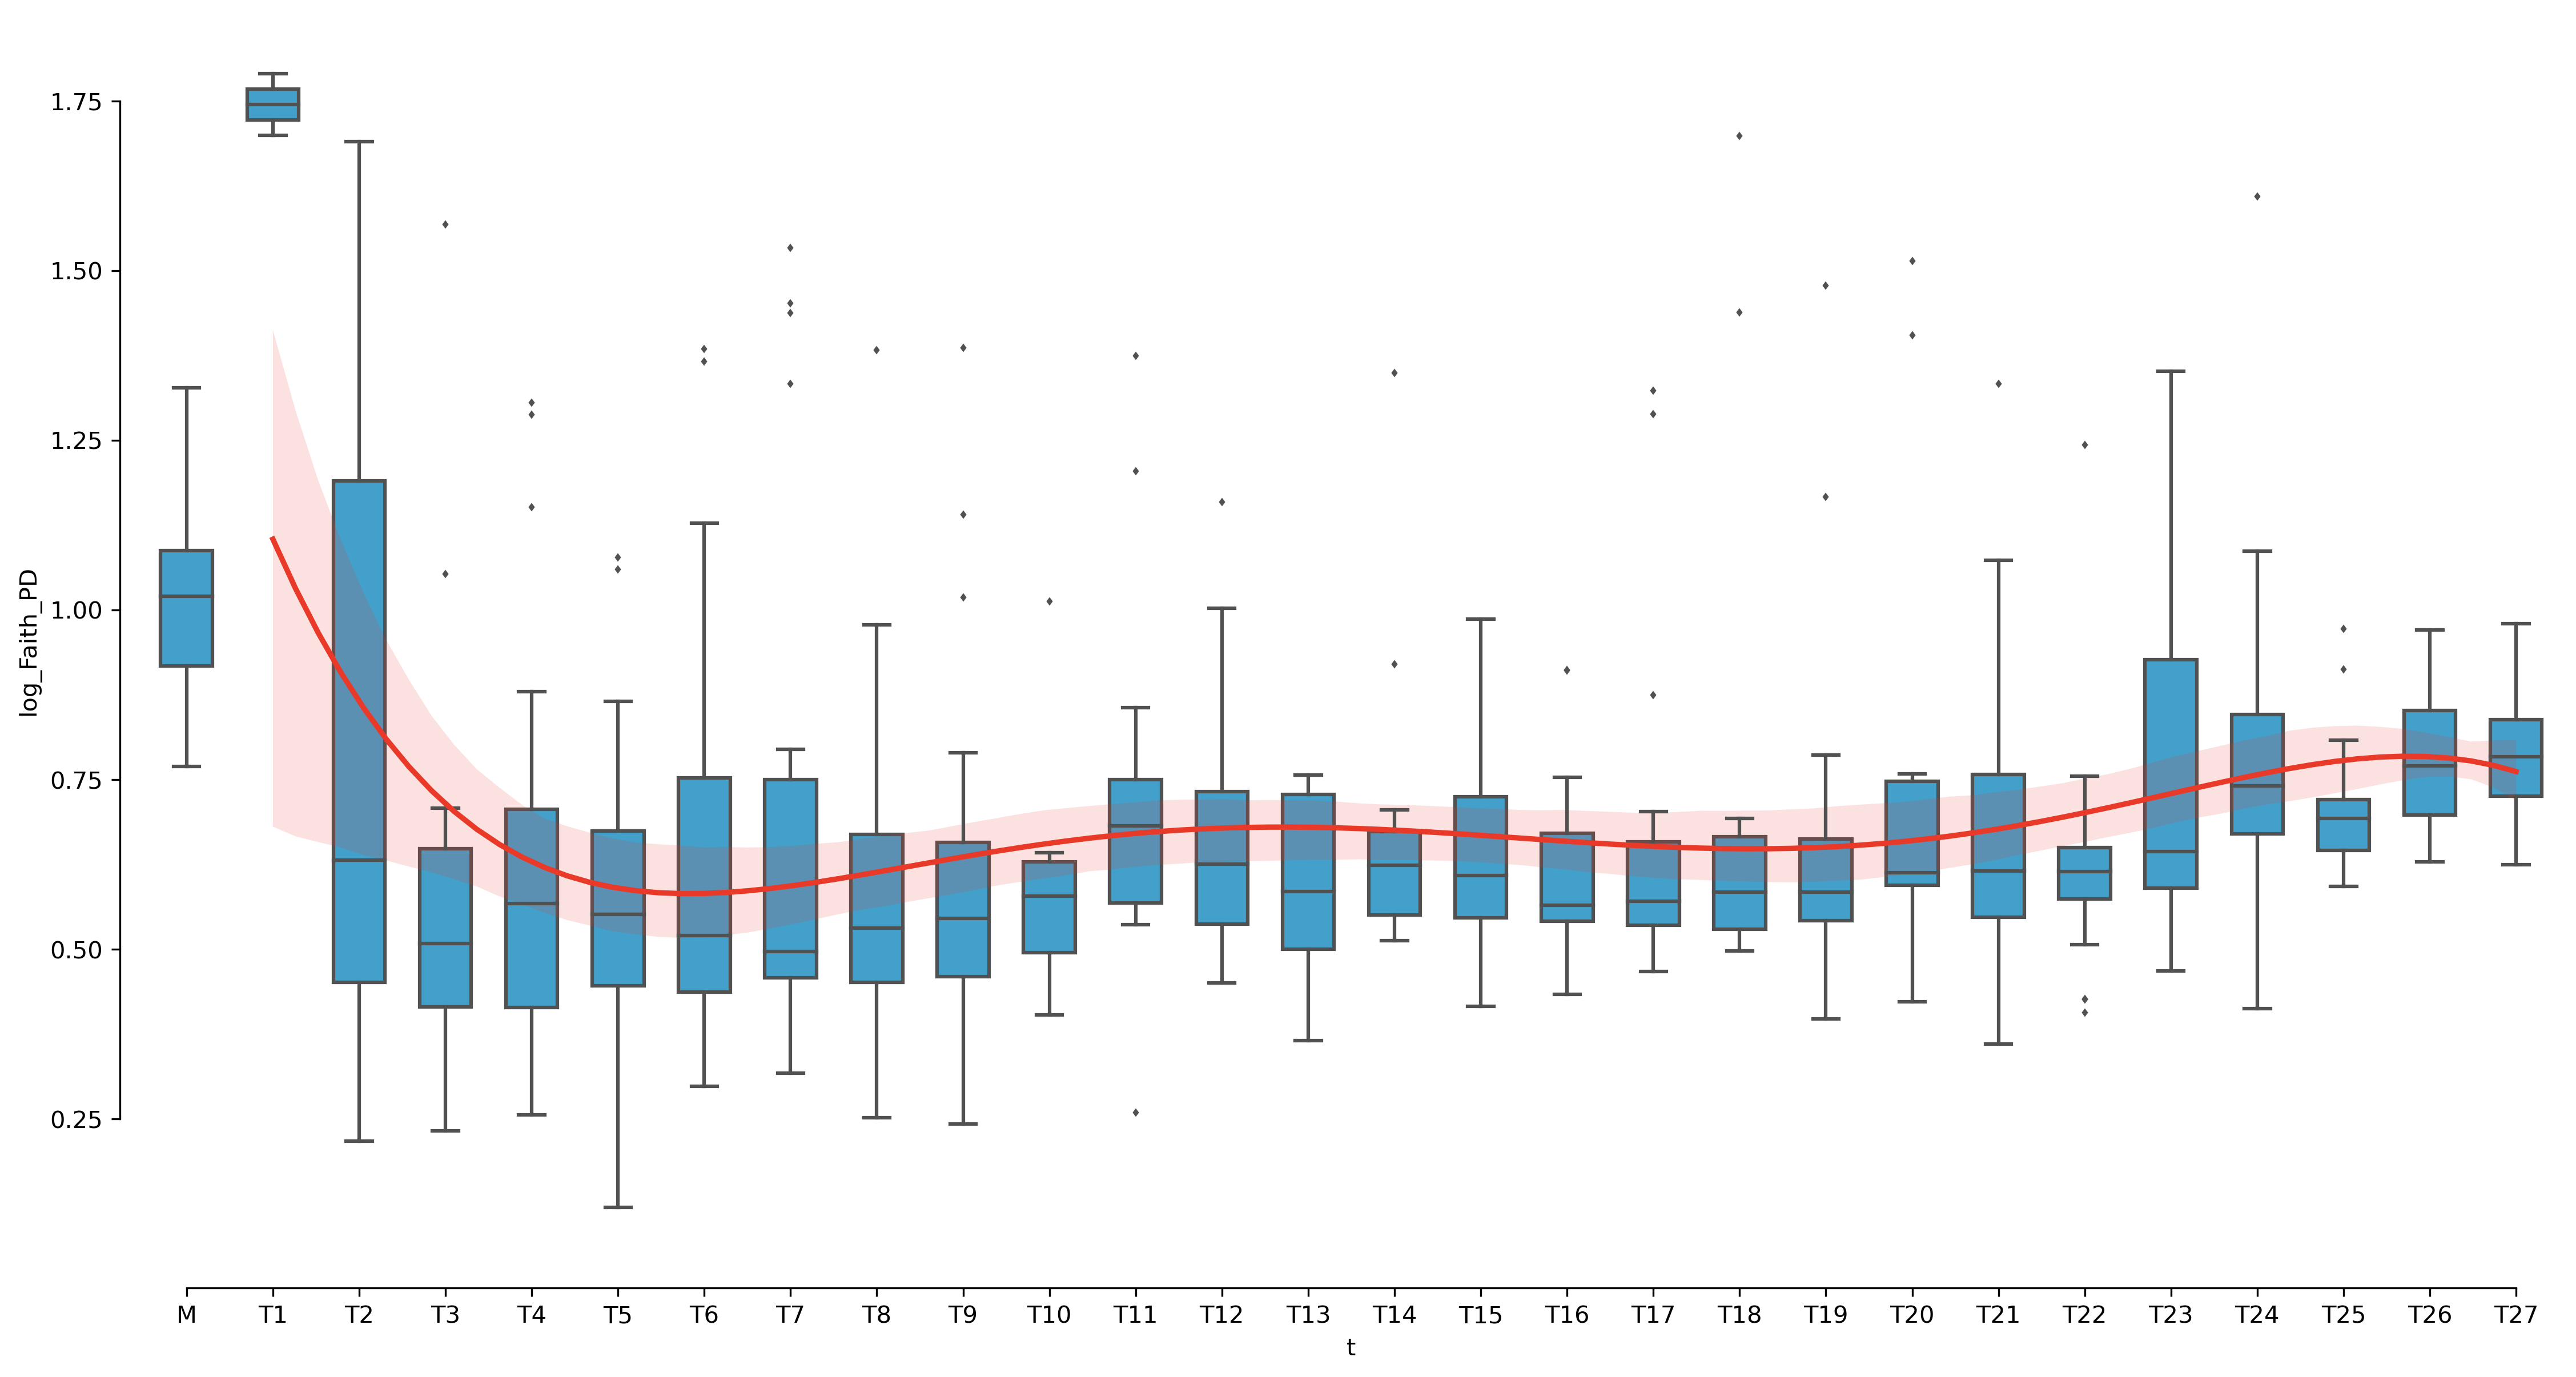

In [6]:
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']

fig = plt.figure(figsize=(15, 8), dpi=300)
ax = sns.boxplot(x="Time", y="log_Faith_PD", data=alpha_diversitys, order=Times, 
                 fliersize=1.5, color='#2ca9e1', width=0.6) #palette='tab20c'
#ax = sns.stripplot(x="Time", y="log_Faith_PD", data=alpha_diversitys, order=Times, palette='tab20c', size=5)
#ax.set_yscale('log')
temp = alpha_diversitys.loc[alpha_diversitys['Time']!='M', :]
temp['t'] = [int(i[1:]) for i in temp['Time']]
ax = sns.regplot(x="t", y="log_Faith_PD", data=temp, order=5, ci=95, scatter=False, n_boot=1000, color='#e83929', 
                 line_kws={'zorder':9})
_ = plt.tight_layout()
_ = sns.despine(offset=10, trim=True)
fig.savefig('../Results_0609/3.1. Alpha_Faith_PD分布情况.pdf', dpi=300)

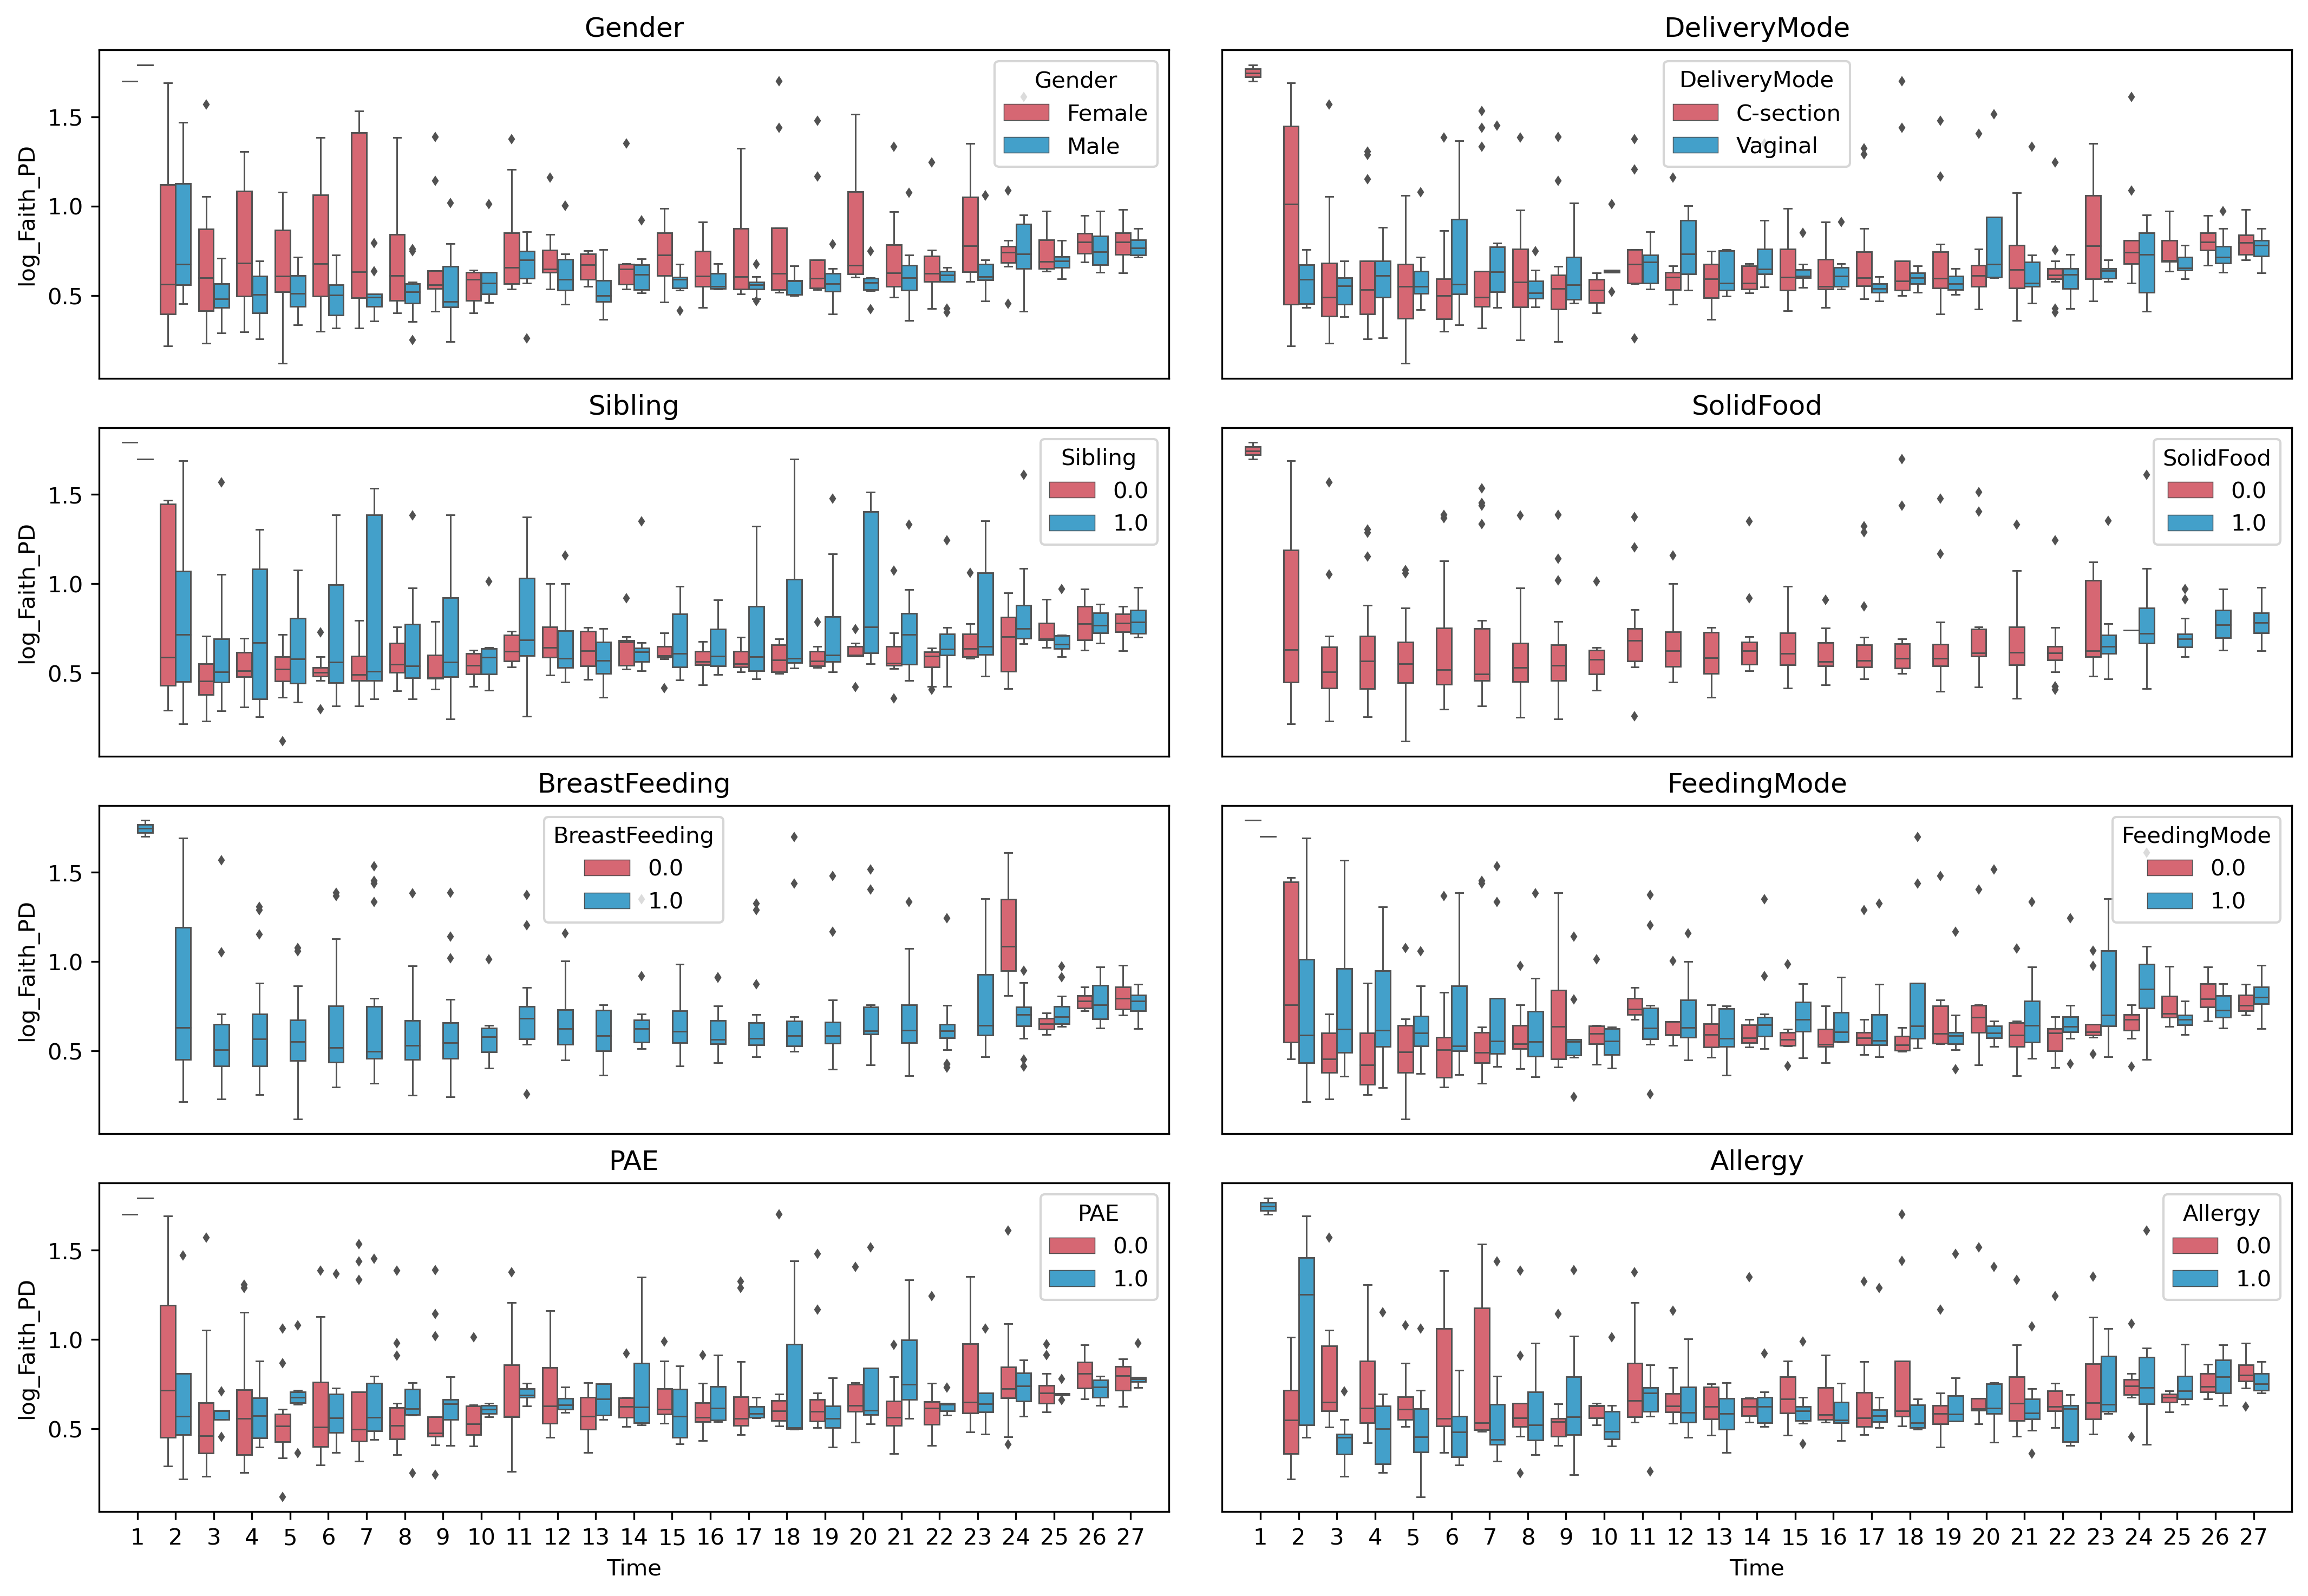

In [7]:
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']

fig = plt.figure(figsize=(15, 10), dpi=300)
gs = gridspec.GridSpec(4, 2, left=0.05, right=0.95, top=0.95, bottom=0.05, 
                       wspace=0.05, hspace=0.15,)
k = 0
hues = ['Gender', 'DeliveryMode', 'Sibling', 'SolidFood', 'BreastFeeding', 'FeedingMode', 'PAE', 'Allergy']
for i in [0, 1, 2, 3]:
    for j in [0, 1]:
        ax = plt.subplot(gs[i, j])
        ax = sns.boxplot(x="Time", y="log_Faith_PD", hue=hues[k], data=alpha_diversitys, order=Times, 
                         fliersize=2, linewidth=0.7, palette=['#e95464', '#2ca9e1'])
        _ = plt.xlim([0, 28])
        if j==1:
            _ = ax.get_yaxis().set_visible(False)
        if i<3:
            _ = ax.get_xaxis().set_visible(False)
        else:
            _ = plt.xticks(range(1, 28), range(1, 28))
        _ = plt.title(hues[k])
        k += 1
fig.savefig('../Results_0609/3.1. Alpha_Faith_PD分布_变量影响.pdf', dpi=300)

# 2. microbial composition （ASV/Species/Genus/）

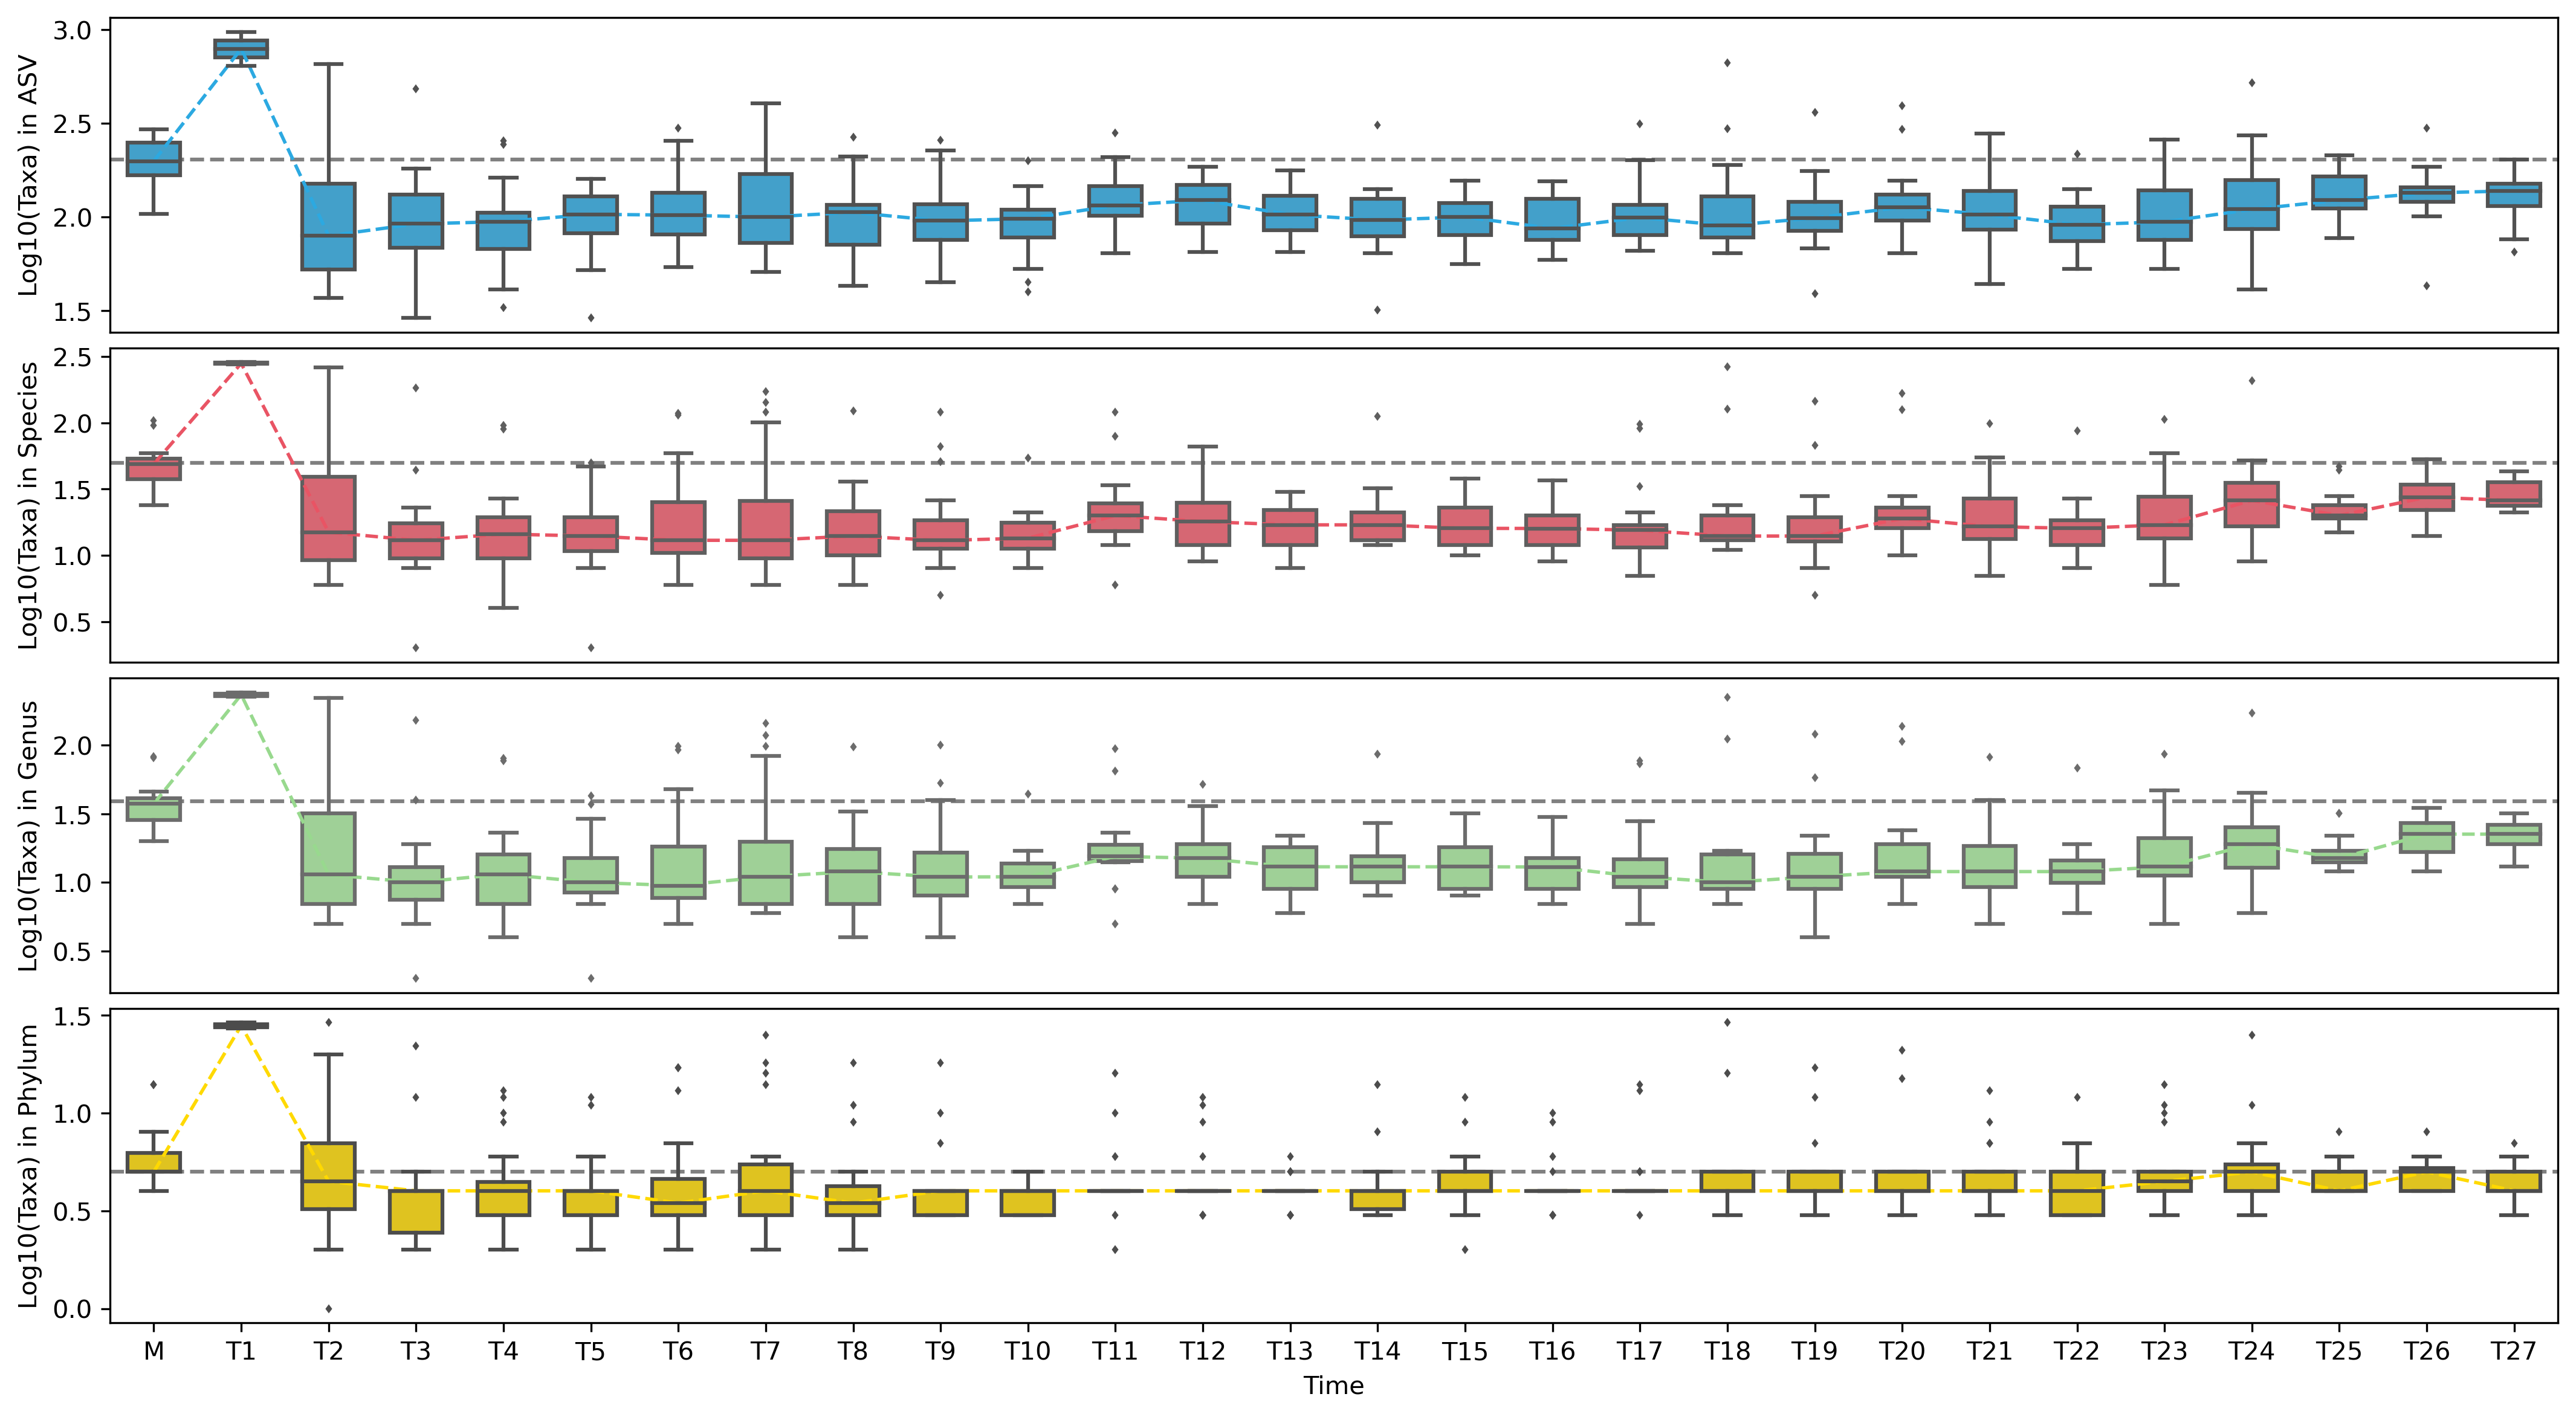

In [8]:
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']

fig = plt.figure(figsize=(15, 8), dpi=300)
gs = gridspec.GridSpec(4, 1, left=0.05, right=0.95, top=0.95, bottom=0.05, 
                       wspace=0.05, hspace=0.05,)
for i, path, level, color in [(0, '../Data/16S/MZJ_dada2_table_ASV.tsv', 'ASV', '#2ca9e1'), 
                               (1, '../Data/16S/DADA2_table/MZJ_dada2_table_L7.tsv', 'Species', '#e95464'),
                               (2, '../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', 'Genus', '#98d98e'), 
                               (3, '../Data/16S/DADA2_table/MZJ_dada2_table_L2.tsv', 'Phylum', '#ffd900')]: 
    ax = plt.subplot(gs[i, 0])
    data = pd.read_csv(path, sep='\t', index_col=0, skiprows=1)
    data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]
    taxa_count = pd.DataFrame((data>0).sum())
    taxa_count.columns = ['Count']
    taxa_count['logCount'] = np.log10(taxa_count['Count'])
    taxa_count['Time'] = meta.loc[taxa_count.index, 'Time']
    ax = sns.pointplot(x="Time", y="logCount", data=taxa_count, order=Times, estimator=np.median,
                     fliersize=1.5, color=color, markers='', errwidth=0, linestyles='--', scale=0.5)
    ax = sns.boxplot(x="Time", y="logCount", data=taxa_count, order=Times, 
                     fliersize=1.5, color=color, width=0.6)
    _ = plt.hlines(y=taxa_count.loc[meta.loc[meta['Sample_type']=='M', :].index, 'logCount'].median(), 
                   xmin=-0.5, xmax=27.5, colors='gray', ls='--',  zorder=-1)
    _ = plt.ylabel('Log10(Taxa) in ' + level)
    if i<3:
        _ = ax.get_xaxis().set_visible(False)
fig.savefig('../Results_0609/3.2. 物种量统计(Count>0).pdf', dpi=300)

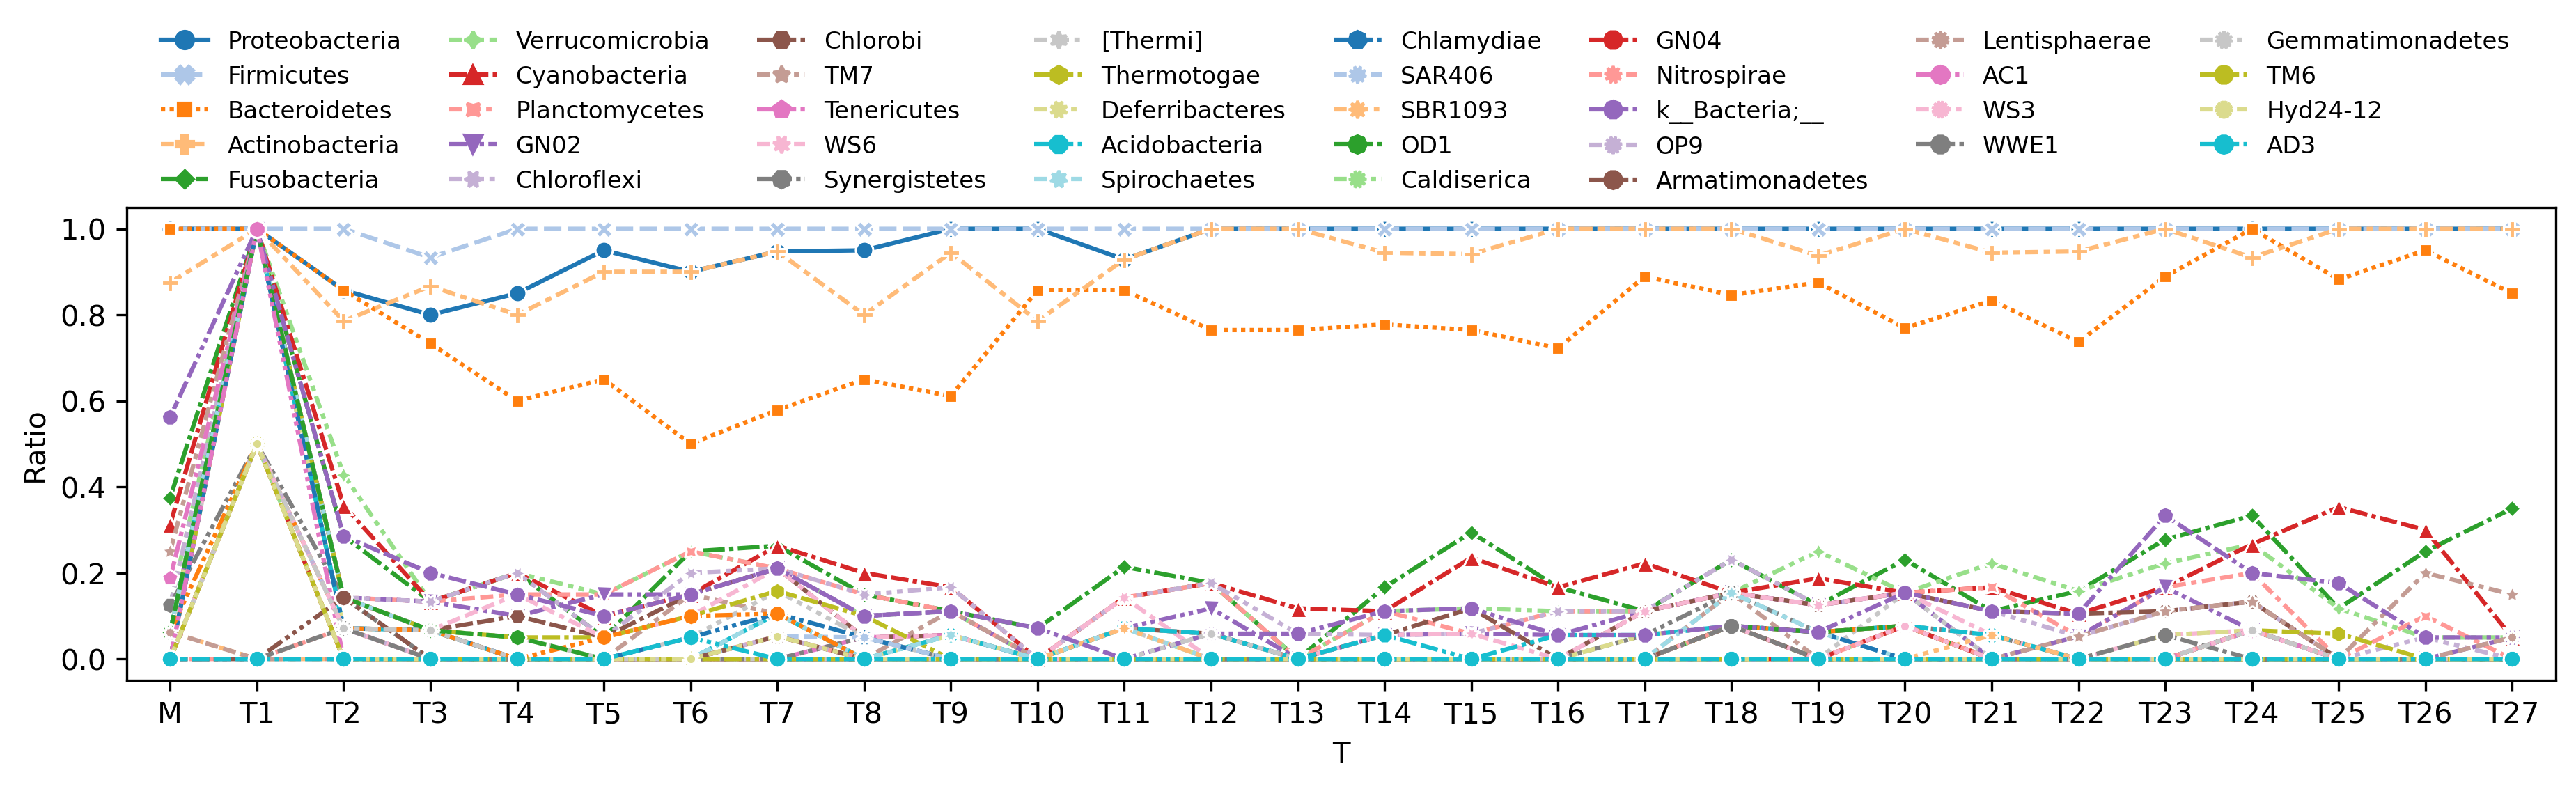

In [9]:
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L2.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
result = pd.DataFrame()
for t in Times:
    taxa_cover = (data.loc[:, meta.loc[meta['Time']==t].index]>0).mean(axis=1)
    #taxa_cover = taxa_cover
    result = pd.concat([result, pd.DataFrame({'T':t, 'Ratio':taxa_cover.values, 
                                           'Taxa':[i.replace('k__Bacteria;p__', '') for i in taxa_cover.index]})], 
                       axis=0)
result.index = range(result.shape[0])
fig = plt.figure(figsize=(15, 3), dpi=300)
_ = sns.lineplot(data=result, x="T", y="Ratio", hue="Taxa", style='Taxa', markers=True, palette='tab20') 
#hue_order=taxa_cover.sort_values(ascending=False).index
_ = plt.xlim([-0.5, 27.5])
_ = plt.legend(loc=(0.01, 1.01), frameon=False, ncol=8, fontsize=8.2)
fig.savefig('../Results_0609/3.2. 物种样本占比_门水平.pdf', dpi=300)

## iTOL Tree of Genus

In [10]:
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]
lineages = [(i, [j.replace('__', '').replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace(',', '').replace('_', '').replace('-', '').replace('_', '').replace(' ', '') for j in i.split(';')]) for i in data.index]
lineages = [(taxa, [j[1:] for j in i]) for taxa, i in lineages if len(i[-1])>1]
taxa_in_tree = [(i, j[-1]) for i, j in lineages]
len(taxa_in_tree)
lineages = [(i[-1], i[:-1])for taxa, i in lineages]
from skbio.tree import TreeNode
tree = TreeNode.from_taxonomy(lineages)
tree_txt = str(tree)
tree_txt

270

'((((((Clostridium,SMB53,CandidatusArthromitus)Clostridiaceae,(Veillonella,Phascolarctobacterium,Megamonas,Megasphaera,Dialister,Acidaminococcus,Selenomonas,Succiniclasticum)Veillonellaceae,(Ruminococcus,Clostridium,Blautia,Robinsoniella,Dorea,Roseburia,Epulopiscium,Lachnospira,Coprococcus,Anaerostipes,Lachnobacterium,Butyrivibrio,Lachnoanaerobaculum,Oribacterium,Shuttleworthia,Moryella)Lachnospiraceae,(Oscillospira,Faecalibacterium,Anaerotruncus,Gemmiger,Ruminococcus,Clostridium,Butyricicoccus)Ruminococcaceae,(Finegoldia,168,GW34,Sedimentibacter,WAL1855D,Peptoniphilus,Anaerococcus,Parvimonas,TissierellaSoehngenia)Tissierellaceae,(Peptostreptococcus,Clostridium,Filifactor)Peptostreptococcaceae,(Pelotomaculum,Peptococcus,rc44,Niigata25)Peptococcaceae,(Guggenheimella)Acidaminobacteraceae,(Syntrophomonas)Syntrophomonadaceae,(PseudoramibacterEubacterium)Eubacteriaceae,(Dehalobacterium)Dehalobacteriaceae,(Mogibacterium)Mogibacteriaceae)Clostridiales)Clostridia,(((Streptococcus,Lactococcus)S

In [11]:
taxa_in_tree[:3]

[('k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium',
  'Clostridium'),
 ('k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides',
  'Bacteroides'),
 ('k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
  'Bifidobacterium')]

In [12]:
### ITOL 创建Dataset, 贴入特征表格
##### Tree Label
colors = ['#e60033', '#ee7800', '#ffd900', '#3eb370', '#0095d9', '#165e83', '#884898']
colors = {'Firmicutes':'#e60033', 'Bacteroidetes':'#ee7800', 'Actinobacteria':'#ffd900', 'Proteobacteria':'#3eb370'}
for i, j in taxa_in_tree:
    p = i.split(';')[1].split('__')[1].strip()
    c = colors.get(p, 'gray')
    print(f"{j}\t{j}\t3\t{c}\tnormal\t1\t0")

Clostridium	Clostridium	3	#e60033	normal	1	0
Bacteroides	Bacteroides	3	#ee7800	normal	1	0
Bifidobacterium	Bifidobacterium	3	#ffd900	normal	1	0
Streptococcus	Streptococcus	3	#e60033	normal	1	0
Veillonella	Veillonella	3	#e60033	normal	1	0
Enterococcus	Enterococcus	3	#e60033	normal	1	0
Ruminococcus	Ruminococcus	3	#e60033	normal	1	0
Lactobacillus	Lactobacillus	3	#e60033	normal	1	0
Clostridium	Clostridium	3	#e60033	normal	1	0
Citrobacter	Citrobacter	3	#3eb370	normal	1	0
Enterobacter	Enterobacter	3	#3eb370	normal	1	0
Phascolarctobacterium	Phascolarctobacterium	3	#e60033	normal	1	0
Haemophilus	Haemophilus	3	#3eb370	normal	1	0
Staphylococcus	Staphylococcus	3	#e60033	normal	1	0
Oscillospira	Oscillospira	3	#e60033	normal	1	0
Sutterella	Sutterella	3	#3eb370	normal	1	0
Propionibacterium	Propionibacterium	3	#ffd900	normal	1	0
Blautia	Blautia	3	#e60033	normal	1	0
Collinsella	Collinsella	3	#ffd900	normal	1	0
Faecalibacterium	Faecalibacterium	3	#e60033	normal	1	0
Prevotella	Prevotella	3	#ee7800	normal

In [13]:
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
for taxa, name in taxa_in_tree:
    res = []
    for t in Times:
        samples = meta.loc[meta['Time']==t].index
        res.append(round((data.loc[taxa, samples]>0).mean(), 2))
    #len(res)
    print(f"{name}\t"+'\t'.join([str(i) for i in res]))
    #taxa_cover = taxa_cover

Clostridium	0.69	1.0	0.79	0.8	0.75	0.7	0.95	0.89	0.85	0.83	0.93	0.93	0.76	0.82	0.89	0.71	0.67	0.78	0.85	0.75	0.92	0.78	0.74	0.78	0.8	0.82	0.95	0.9
Bacteroides	1.0	1.0	0.86	0.73	0.55	0.65	0.5	0.58	0.6	0.61	0.79	0.86	0.76	0.65	0.72	0.71	0.72	0.78	0.77	0.81	0.69	0.78	0.68	0.89	0.87	0.71	0.7	0.75
Bifidobacterium	0.69	1.0	0.64	0.73	0.6	0.7	0.75	0.68	0.7	0.78	0.64	0.93	0.76	1.0	0.83	0.94	0.89	0.78	0.85	0.81	1.0	0.89	0.89	1.0	0.93	1.0	0.95	1.0
Streptococcus	0.5	1.0	1.0	0.93	1.0	0.95	1.0	1.0	1.0	1.0	1.0	0.93	1.0	0.94	1.0	1.0	1.0	0.89	1.0	0.81	0.92	0.89	0.74	0.78	0.8	0.82	0.65	0.75
Veillonella	0.25	0.5	0.36	0.27	0.4	0.45	0.4	0.53	0.65	0.5	0.79	0.64	0.65	0.65	0.83	0.71	0.67	0.5	0.69	0.69	0.85	0.78	0.79	1.0	0.8	1.0	1.0	0.85
Enterococcus	0.12	1.0	0.5	0.53	0.75	0.6	0.7	0.74	0.65	0.44	0.57	0.71	0.76	0.53	0.61	0.41	0.44	0.5	0.54	0.5	0.46	0.44	0.37	0.5	0.67	0.59	0.5	0.3
Ruminococcus	0.69	1.0	0.36	0.2	0.1	0.05	0.05	0.16	0.1	0.11	0.21	0.29	0.12	0.29	0.11	0.18	0.11	0.11	0.23	0.12	0.31	0.22	0.26	0.28	0.33

# 3. Beta diversity

In [3]:
from skbio.stats.distance import bioenv
from skbio import DistanceMatrix
def get_bioenv(matrix, envs, term):
    envs = envs[[term]].dropna()
    dm = DistanceMatrix(distance_matrix.loc[envs.index, envs.index].values, envs.index)
    r = bioenv(dm, envs)['correlation'][0]
    p = 1
    for i in range(999):
        np.random.shuffle(envs[term])
        rr = bioenv(dm, envs)['correlation'][0]
        if (r>=0 and rr>=r) or (r<0 and rr<=r):
            p += 1
    return envs.shape[0], r, p/1000.

In [6]:
corr = pd.read_csv('../Results_0609/3.3. Beta多样性_weighted_unifrac_bioenv.csv', index_col=0)
corr
corr = pd.read_csv('../Results_0609/3.3. Beta多样性_unweighted_unifrac_bioenv.csv', index_col=0)
corr

N         R   Pval
Time           450  0.128290  0.001
Gender         450  0.017264  0.001
DeliveryMode   450  0.212338  0.001
SolidFood      450  0.103664  0.001
BreastFeeding  450  0.050031  0.041
FeedingMode    445  0.022409  0.003
Sibling        430  0.009202  0.036
PAE            450  0.097981  0.001
Allergy        450  0.042987  0.001

N         R   Pval
Time           450  0.159101  0.001
Gender         450  0.056052  0.001
DeliveryMode   450  0.046230  0.004
SolidFood      450  0.096439  0.005
BreastFeeding  450  0.092840  0.008
FeedingMode    445  0.024530  0.001
Sibling        430  0.022651  0.003
PAE            450 -0.006117  0.410
Allergy        450  0.034890  0.001

PC1    0.363401
PC2    0.181520
PC3    0.103862
dtype: float64

21

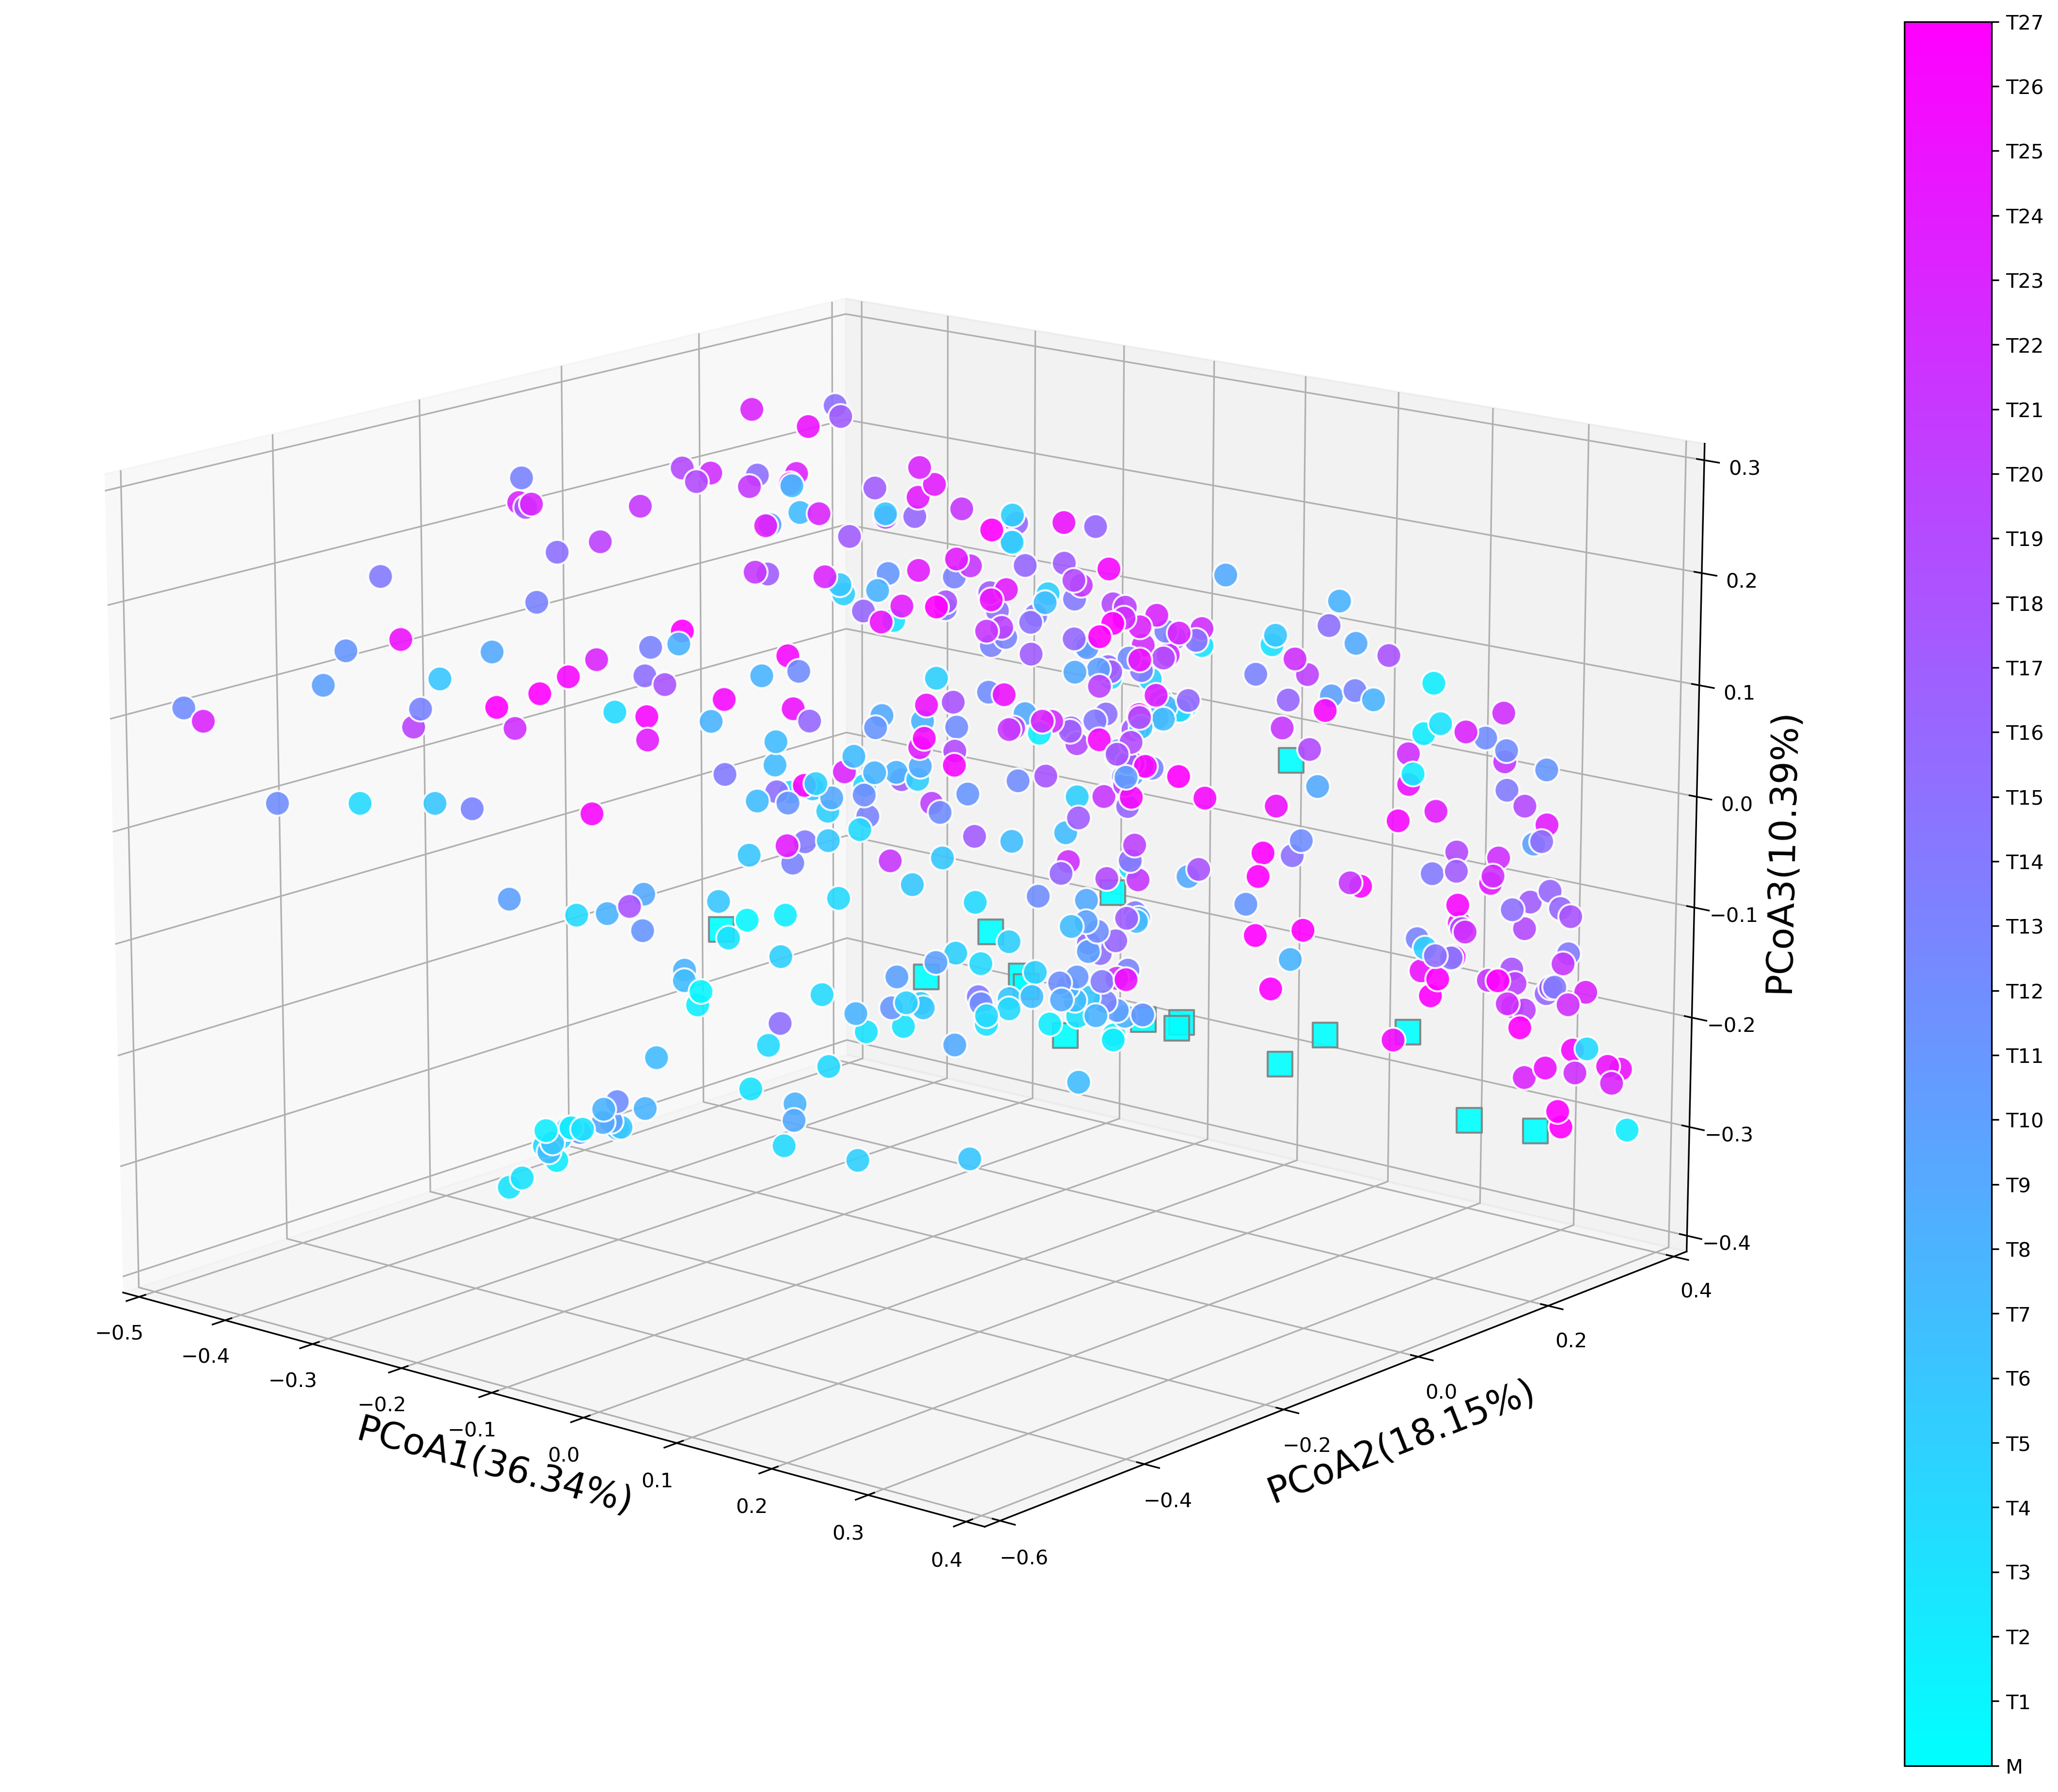

In [4]:
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

distance_matrix = pd.read_csv('../Results/1.3. Beta_weighted_unifrac_matrix.csv', index_col=0)
dm = DistanceMatrix(distance_matrix.values, list(distance_matrix.index))
pcs = pcoa(dm)
pcs.proportion_explained.head(3)
#pcs.samples.head(2)

pdata = pcs.samples[['PC1', 'PC2', 'PC3']]
pdata['Time'] = meta.loc[pdata.index, 'Time']
pdata['Sample_type'] = meta.loc[pdata.index, 'Sample_type']
pdata['MotherID'] = meta.loc[pdata.index, 'MotherID']
pdata['Child_ID'] = meta.loc[pdata.index, 'Child_ID']

Childs = [1, 4, 5, 11, 12, '13L', '13S', 14, 15, 18, 19, 21, 25, 26, 28, 29, 31, 32, 33, 34, 35]
Times = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
family_links = {}
for c in Childs:
    MID = pdata.loc[pdata['Child_ID']==str(c), 'MotherID'].values[0]
    CTimes = pdata.loc[pdata['Child_ID']==str(c), 'Time'].values
    #c, MID, CTimes
    sample_seq = [] if str(MID).upper()=='NAN' else [MID]
    sample_seq.extend([pdata.loc[(pdata['Time']==i)&(pdata['Child_ID']==str(c)), :].index[0] for i in Times if i in CTimes])
    family_links[str(c)] = sample_seq
len(family_links)

### Plot
import matplotlib
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D

Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
cs = [Times.index(i) for i in pdata['Time']]
cm = plt.get_cmap('cool')
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(20, 12), dpi=300)
ax = Axes3D(fig)

cs = [Times.index(i) for i in pdata.loc[pdata['Time']=='M', 'Time']]
_ = ax.scatter(pdata.loc[pdata['Time']=='M', 'PC1'].values, 
               pdata.loc[pdata['Time']=='M', 'PC2'].values, 
               pdata.loc[pdata['Time']=='M', 'PC3'].values, 
               c=scalarMap.to_rgba(cs), s=150, lw=1, ec='gray', alpha=0.9, marker='s')

cs = [Times.index(i) for i in pdata.loc[pdata['Time']!='M', 'Time']]
_ = ax.scatter(pdata.loc[pdata['Time']!='M', 'PC1'].values, 
               pdata.loc[pdata['Time']!='M', 'PC2'].values, 
               pdata.loc[pdata['Time']!='M', 'PC3'].values, 
               c=scalarMap.to_rgba(cs), s=150, lw=1, ec='white', alpha=0.9, marker='o')

_ = scalarMap.set_array(cs)
cbar = fig.colorbar(scalarMap, ticks=range(len(Times)))
_ = cbar.ax.set_yticklabels(Times)
_ = ax.view_init(elev=15, azim=310)# 仰角, 方位角
_ = ax.set_xlim(-0.5, 0.4)
_ = ax.set_ylim(-0.6, 0.4)
_ = ax.set_zlim(-0.4, 0.3)
_ = ax.set_xlabel('PCoA1(36.34%)', fontsize=18)
_ = ax.set_ylabel('PCoA2(18.15%)', fontsize=18)
_ = ax.set_zlabel('PCoA3(10.39%)', fontsize=18)

fig.savefig('../Results_0609/3.3. Beta_PCoA_weighted_unifrac(norm).pdf', dpi=300)

PC1    0.191061
PC2    0.091460
PC3    0.064065
dtype: float64

21

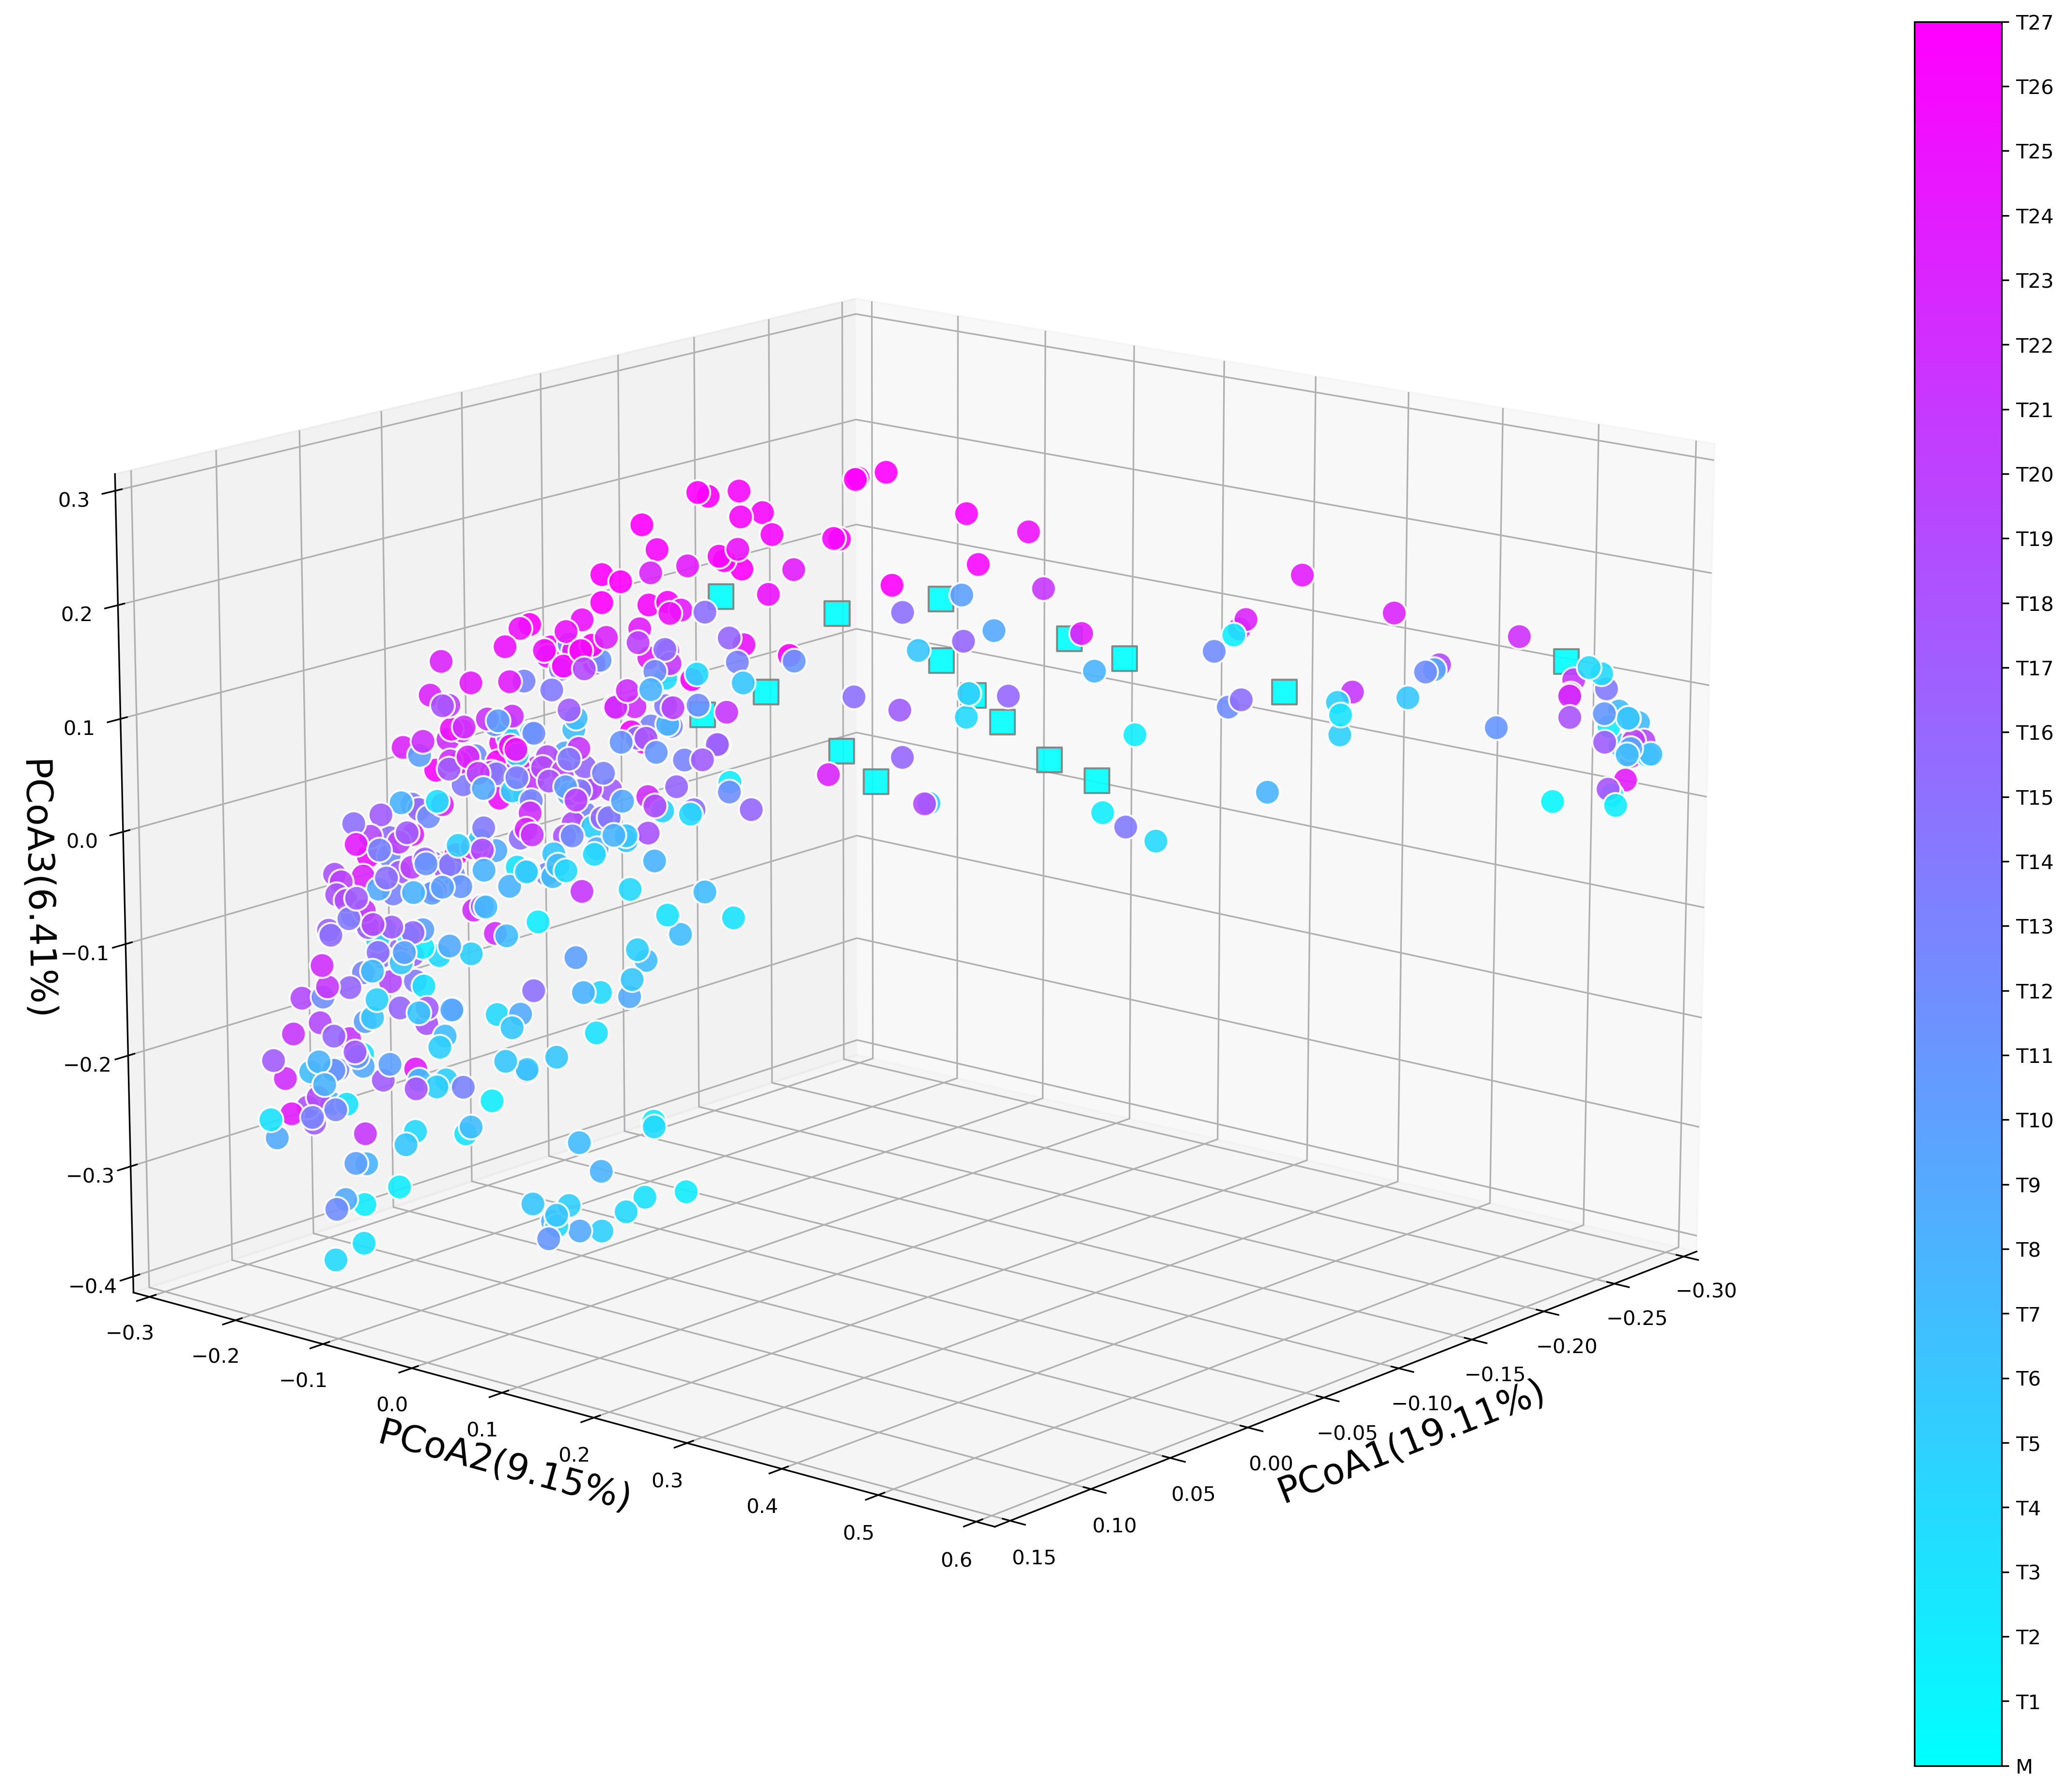

In [5]:
distance_matrix = pd.read_csv('../Results/1.3. Beta_unweighted_unifrac_matrix.csv', index_col=0)
dm = DistanceMatrix(distance_matrix.values, list(distance_matrix.index))
pcs = pcoa(dm)
pcs.proportion_explained.head(3)
#pcs.samples.head(2)

pdata = pcs.samples[['PC1', 'PC2', 'PC3']]
pdata['Time'] = meta.loc[pdata.index, 'Time']
pdata['Sample_type'] = meta.loc[pdata.index, 'Sample_type']
pdata['MotherID'] = meta.loc[pdata.index, 'MotherID']
pdata['Child_ID'] = meta.loc[pdata.index, 'Child_ID']
Childs = [1, 4, 5, 11, 12, '13L', '13S', 14, 15, 18, 19, 21, 25, 26, 28, 29, 31, 32, 33, 34, 35]
Times = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
family_links = {}
for c in Childs:
    MID = pdata.loc[pdata['Child_ID']==str(c), 'MotherID'].values[0]
    CTimes = pdata.loc[pdata['Child_ID']==str(c), 'Time'].values
    #c, MID, CTimes
    sample_seq = [] if str(MID).upper()=='NAN' else [MID]
    sample_seq.extend([pdata.loc[(pdata['Time']==i)&(pdata['Child_ID']==str(c)), :].index[0] for i in Times if i in CTimes])
    family_links[str(c)] = sample_seq
len(family_links)

### Plot
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
cs = [Times.index(i) for i in pdata['Time']]
cm = plt.get_cmap('cool')
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(20, 12), dpi=300)
ax = Axes3D(fig)
cs = [Times.index(i) for i in pdata.loc[pdata['Time']=='M', 'Time']]
_ = ax.scatter(pdata.loc[pdata['Time']=='M', 'PC1'].values, 
               pdata.loc[pdata['Time']=='M', 'PC2'].values, 
               pdata.loc[pdata['Time']=='M', 'PC3'].values, 
               c=scalarMap.to_rgba(cs), s=150, lw=1, ec='gray', alpha=0.9, marker='s')

cs = [Times.index(i) for i in pdata.loc[pdata['Time']!='M', 'Time']]
_ = ax.scatter(pdata.loc[pdata['Time']!='M', 'PC1'].values, 
               pdata.loc[pdata['Time']!='M', 'PC2'].values, 
               pdata.loc[pdata['Time']!='M', 'PC3'].values, 
               c=scalarMap.to_rgba(cs), s=150, lw=1, ec='white', alpha=0.9, marker='o')
_ = scalarMap.set_array(cs)
cbar = fig.colorbar(scalarMap, ticks=range(len(Times)))
_ = cbar.ax.set_yticklabels(Times)
_ = ax.view_init(elev=15, azim=40)# 仰角, 方位角
_ = ax.set_xlim(-0.3, 0.15)
_ = ax.set_ylim(-0.3, 0.6)
_ = ax.set_zlim(-0.4, 0.3)
_ = ax.set_xlabel('PCoA1(19.11%)', fontsize=18)
_ = ax.set_ylabel('PCoA2(9.15%)', fontsize=18)
_ = ax.set_zlabel('PCoA3(6.41%)', fontsize=18)

fig.savefig('../Results_0609/3.3. Beta_PCoA_unweighted_unifrac.pdf', dpi=300)

## Beta diversity vs. clinical groups

In [3]:
from skbio.stats.distance import anosim, permanova
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
def beta_group_compare(meta, matrix, group, group_order):
    Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
             'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
    pdata = []
    pvals = []
    for t in Times[1:]:
        samples = meta.loc[(meta['Time']==t)&(meta['Sample_type']=='C'), :].index
        samples = [i for i in samples if str(meta.loc[i, group])!='nan']
        dm = DistanceMatrix(matrix.loc[samples, samples].values, samples)
        try:
            p = anosim(dm, grouping=list(meta.loc[samples, group]))['p-value']
        except:
            p = 1.0
        pvals.append(p)
        for i in range(len(samples)-1):
            for j in range(i+1, len(samples)):
                group_pair = '-'.join(sorted([str(meta.loc[samples[i], group])[0].upper(), 
                                              str(meta.loc[samples[j], group])[0].upper()]))
                pdata.append([t, samples[i], samples[j], group_pair, matrix.loc[samples[i], samples[j]]])
    ### M-M
    samples = meta.loc[meta['Time']=='M', :].index
    for i in range(len(samples)-1):
        for j in range(i+1, len(samples)):
            pdata.append(['M', samples[i], samples[j], group_order[1], matrix.loc[samples[i], samples[j]]])
    pdata = pd.DataFrame(pdata, columns=['Time', 'i', 'j', group, 'distance'])
    ### Plot
    fig = plt.figure(figsize=(25, 5), dpi=300)
    ax = sns.boxplot(x="Time", y="distance", data=pdata, order=Times, fliersize=5, palette='pastel', 
                     hue=group, hue_order=group_order, width=0.8)
    _ = plt.hlines(y=pdata.loc[pdata['Time']=='M', 'distance'].median(), xmin=-0.5, xmax=27.5, color='k', ls='--')
    
    ymin = pdata['distance'].min()-0.05*(pdata['distance'].max()-pdata['distance'].min())
    ymax = pdata['distance'].max()+0.1*(pdata['distance'].max()-pdata['distance'].min())
    _ = plt.ylim([pdata['distance'].min(), pdata['distance'].max()])
    for i in range(len(pvals)):
        if pvals[i]<=0.01:
            _ = plt.annotate('**', (i+1-0.22, ymax-(ymax-ymin)*0.08), fontsize=18)
        elif pvals[i]<=0.05:
            _ = plt.annotate('*', (i+1-0.12, ymax-(ymax-ymin)*0.08), fontsize=18)
        else:
            pass
    _ = plt.ylim([ymin, ymax])
    return fig

#distance_matrix = pd.read_csv('../Results/1.3. Beta_weighted_unifrac_matrix.csv', index_col=0)
#fig = beta_group_compare(meta, distance_matrix, 'Gender', ['M-M', 'F-M', 'F-F'])

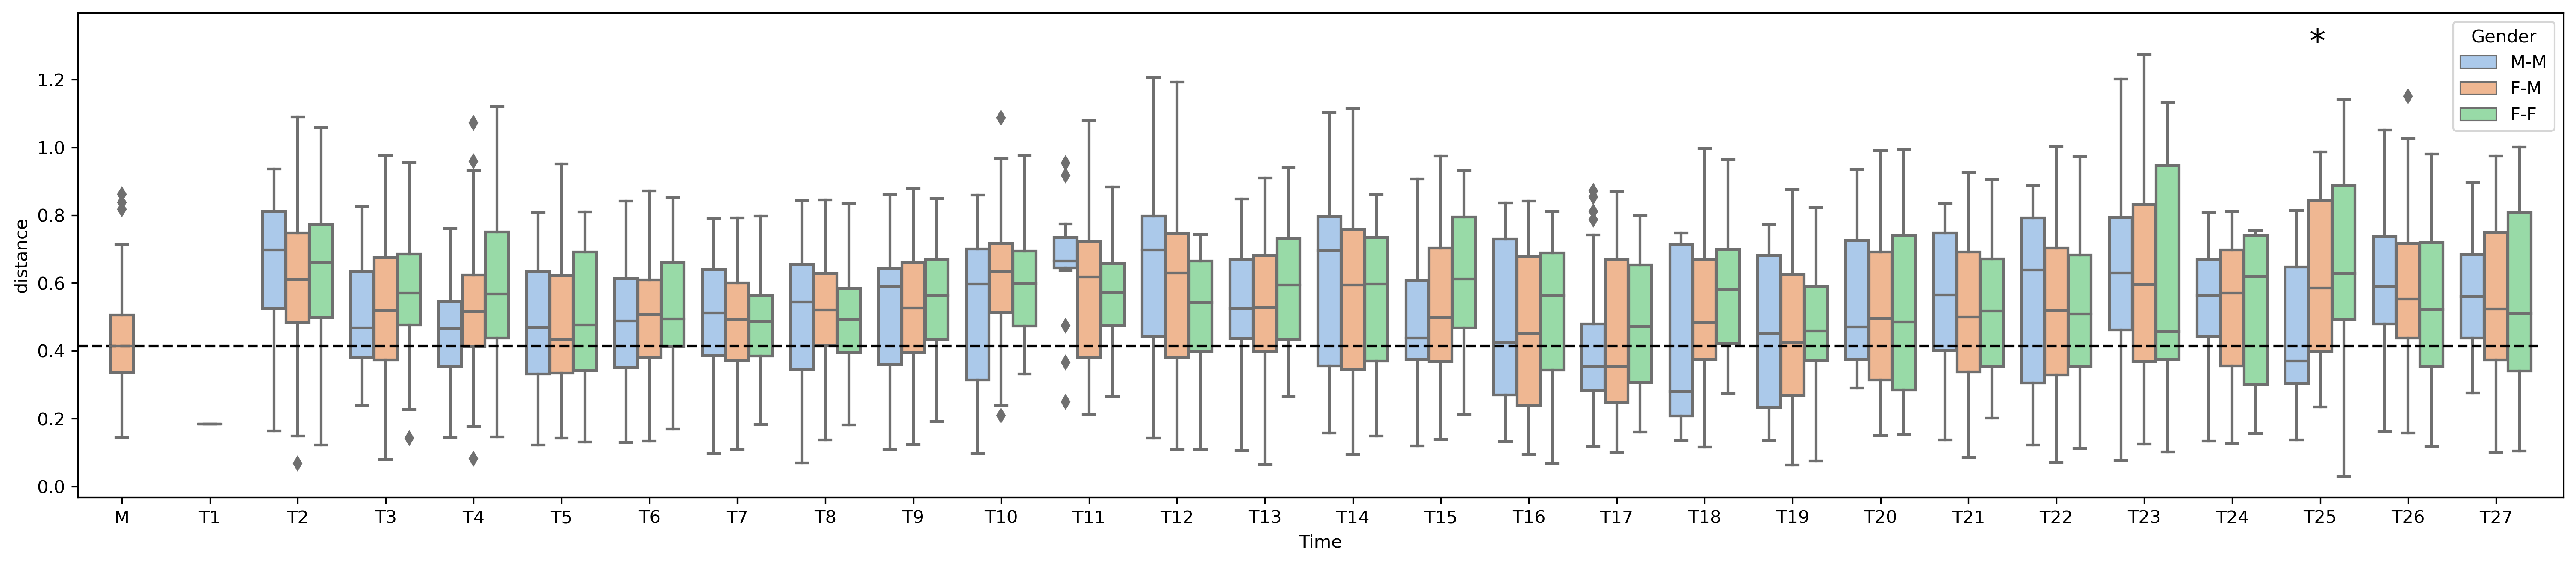

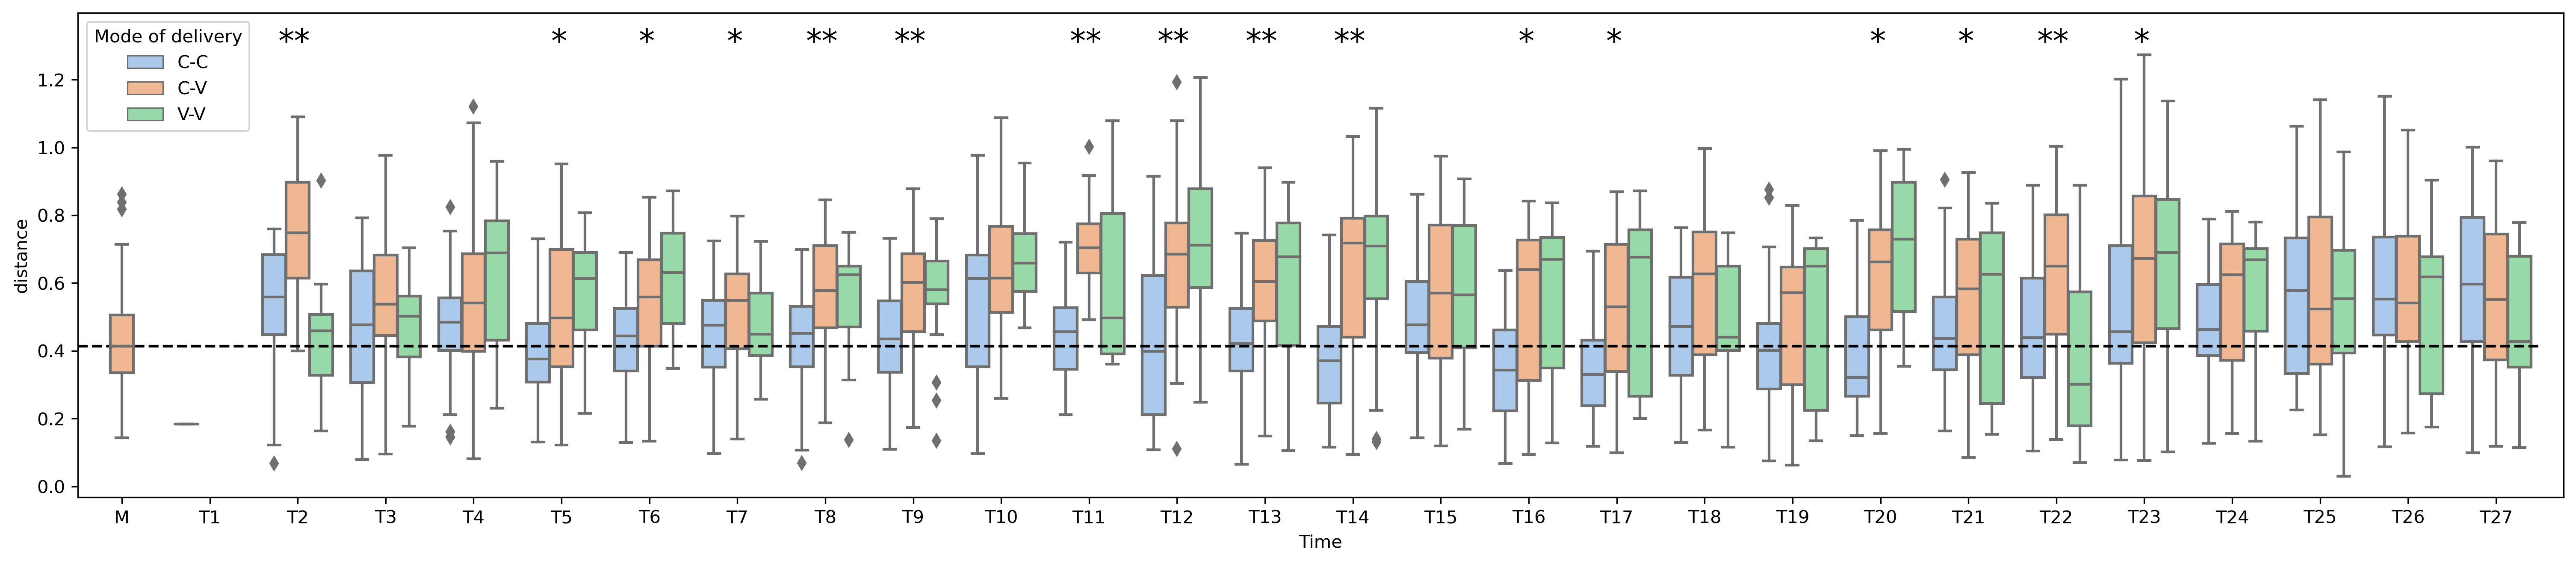

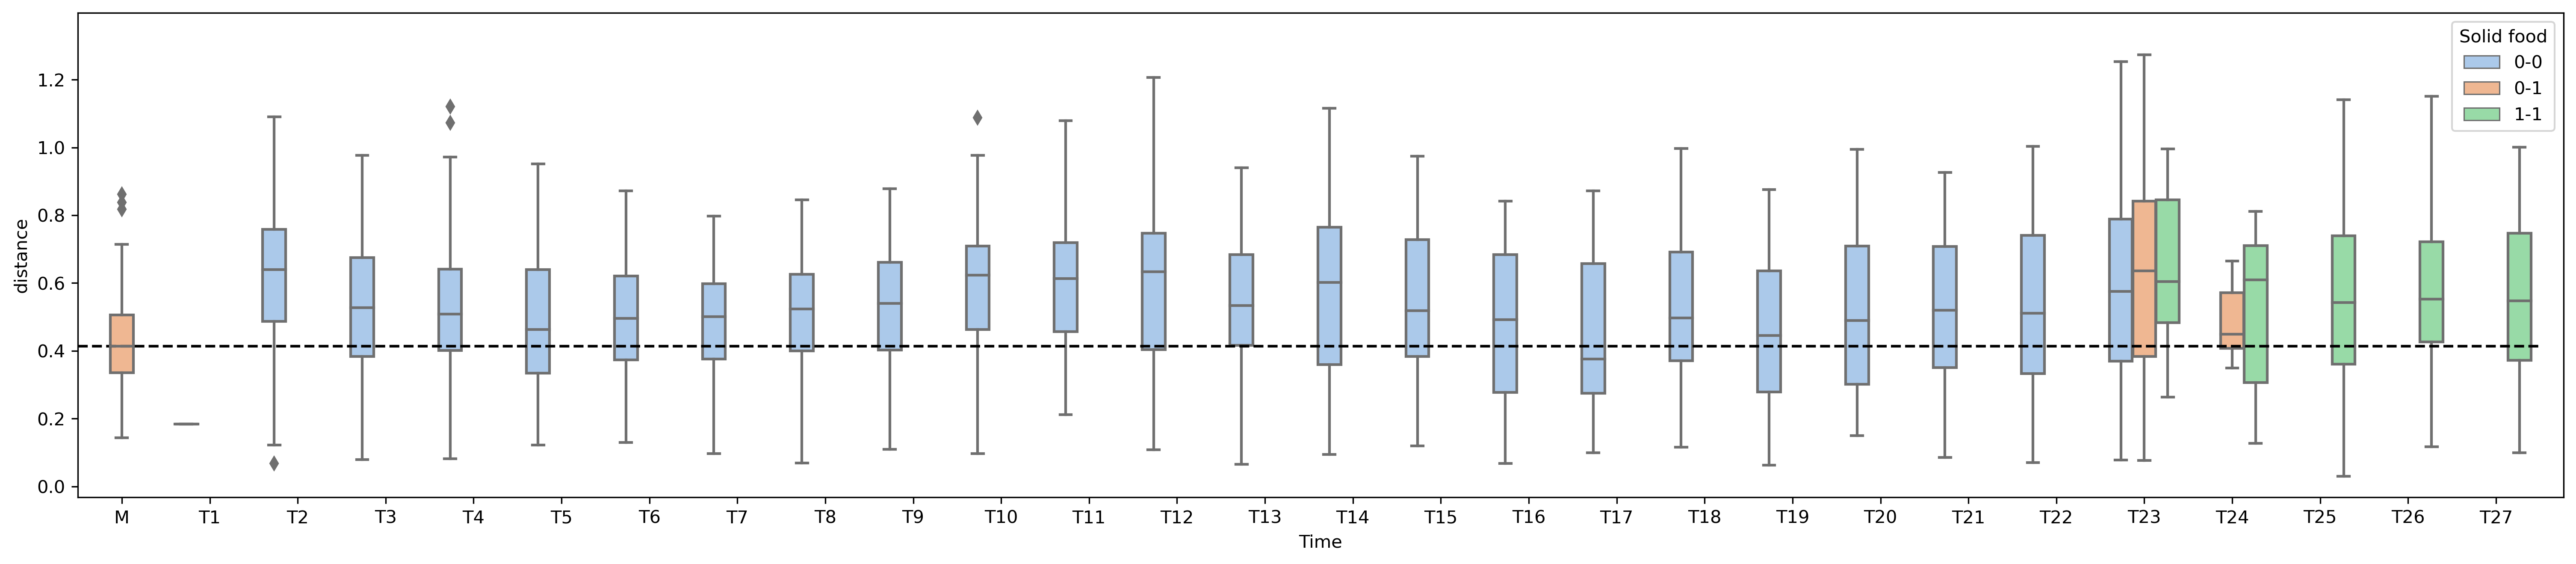

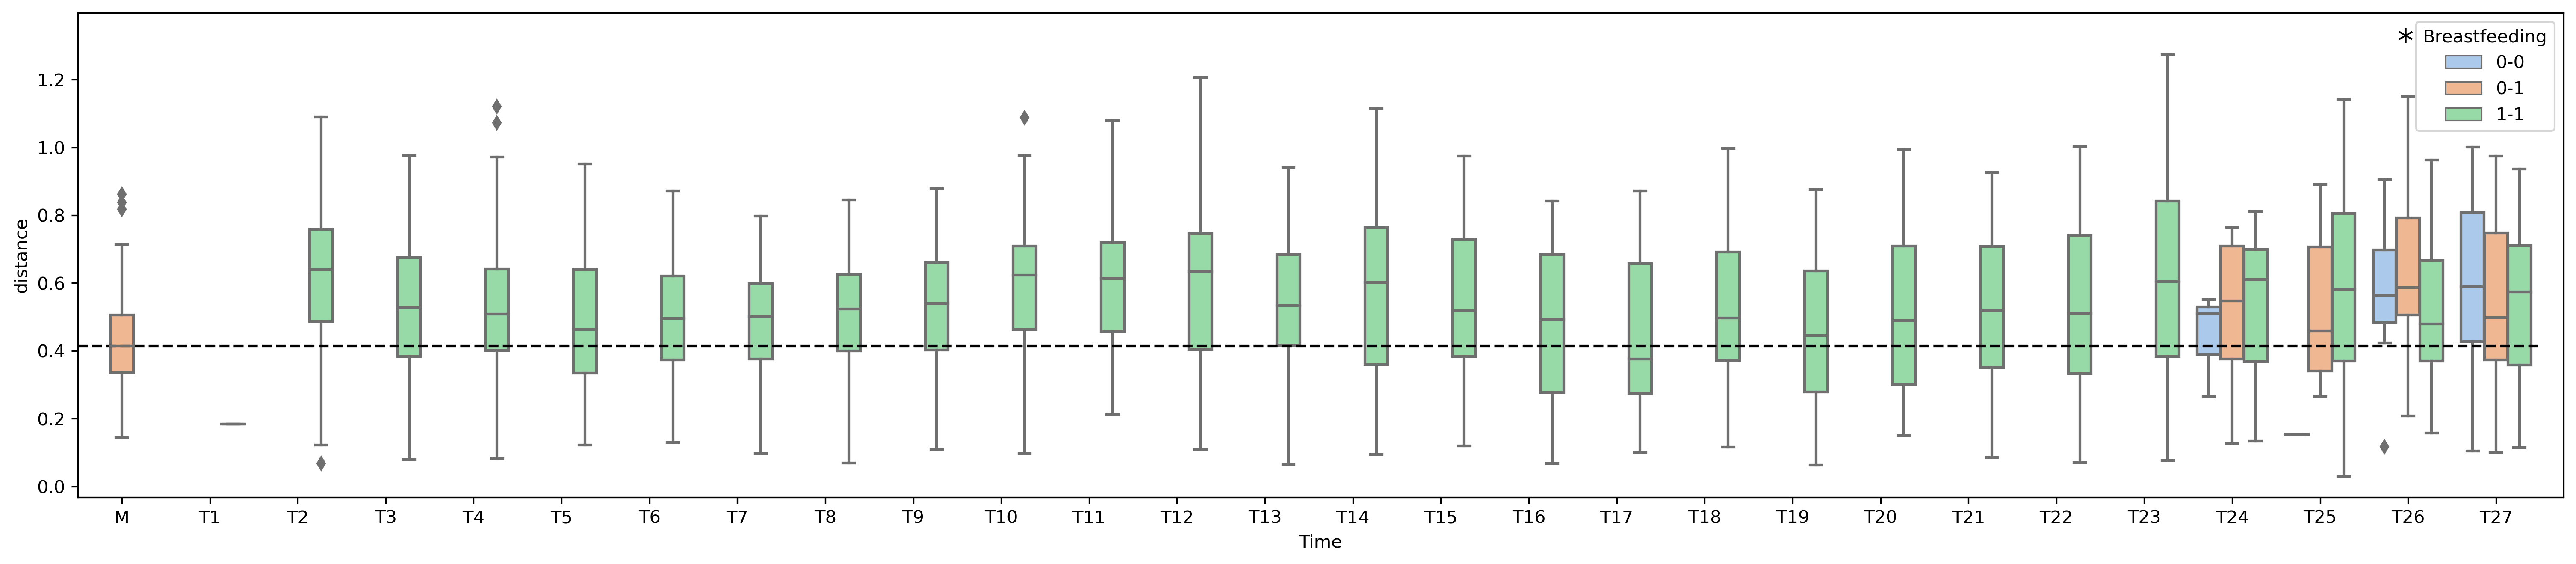

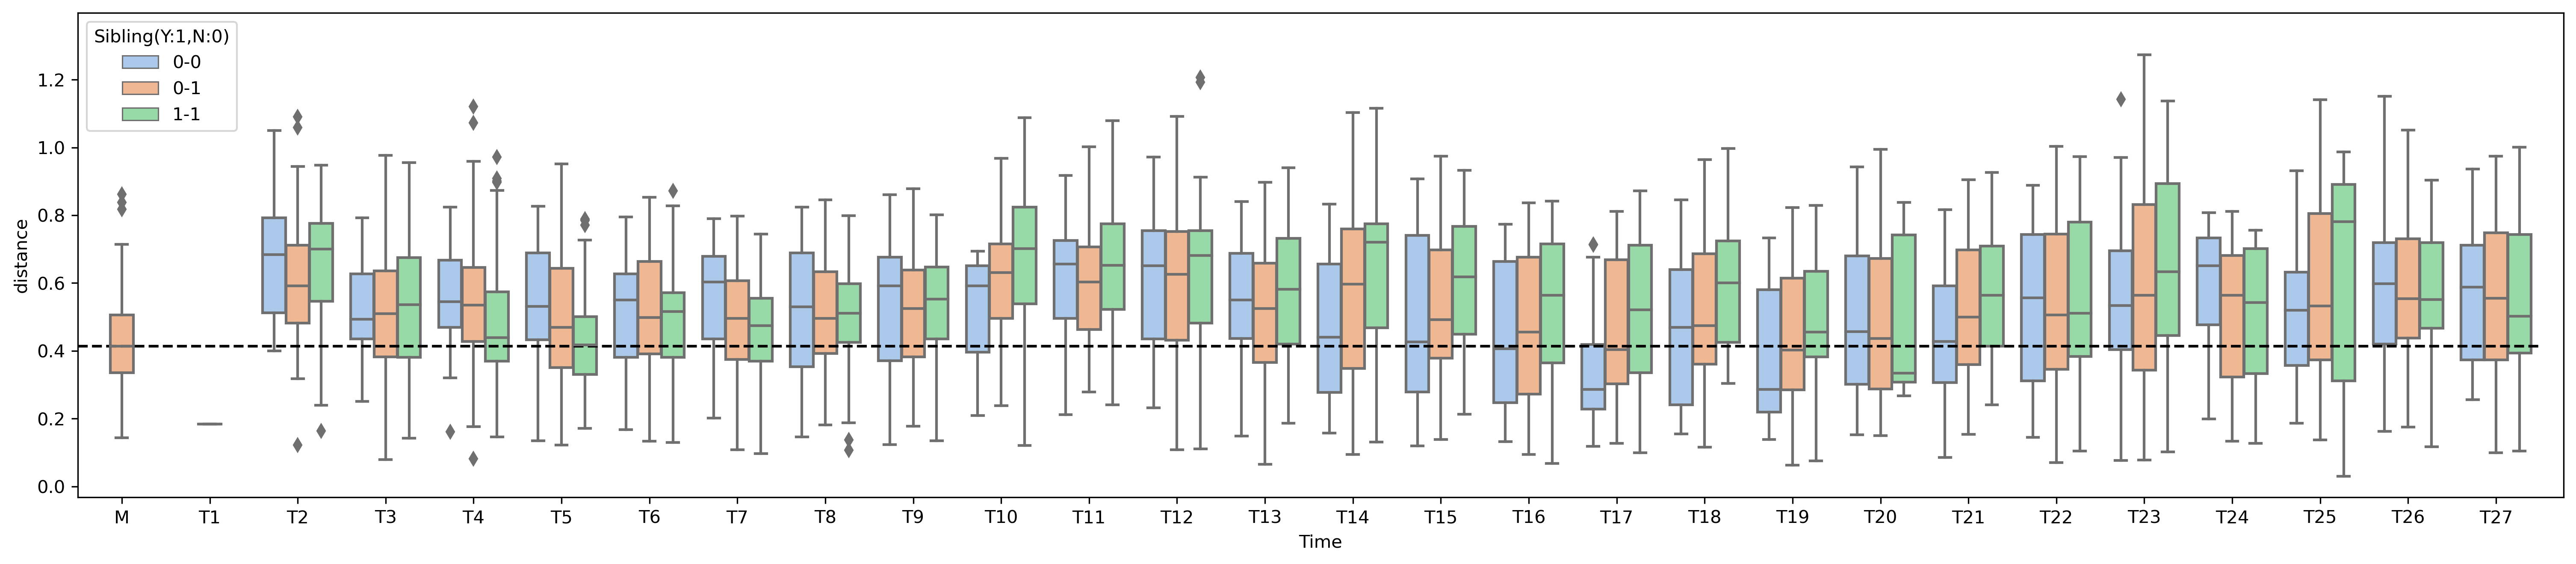

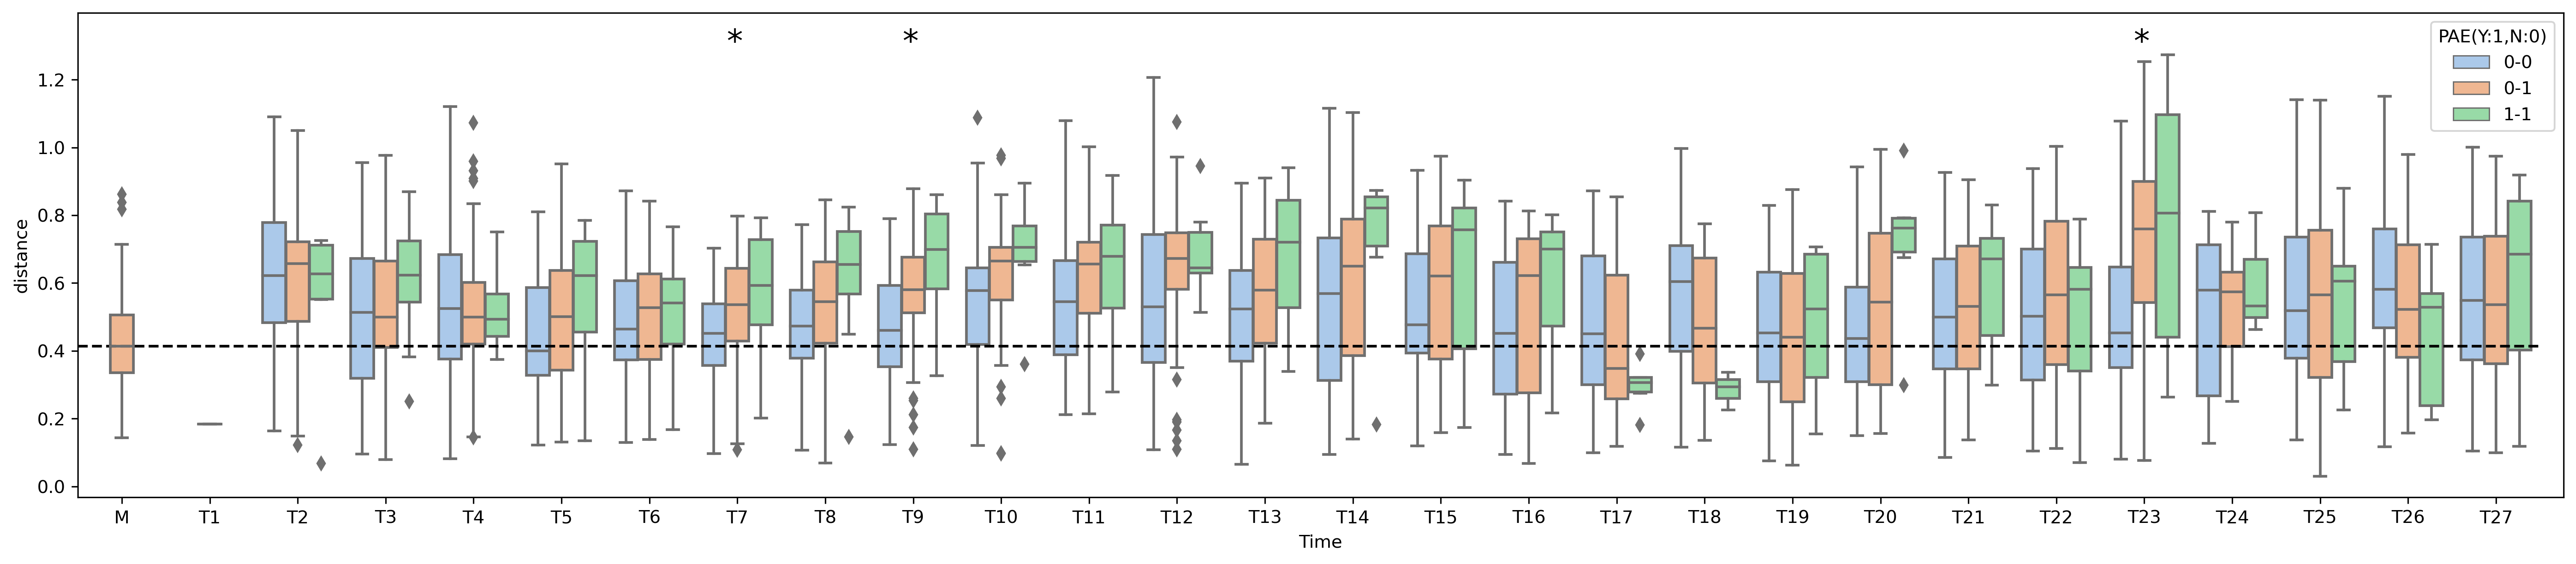

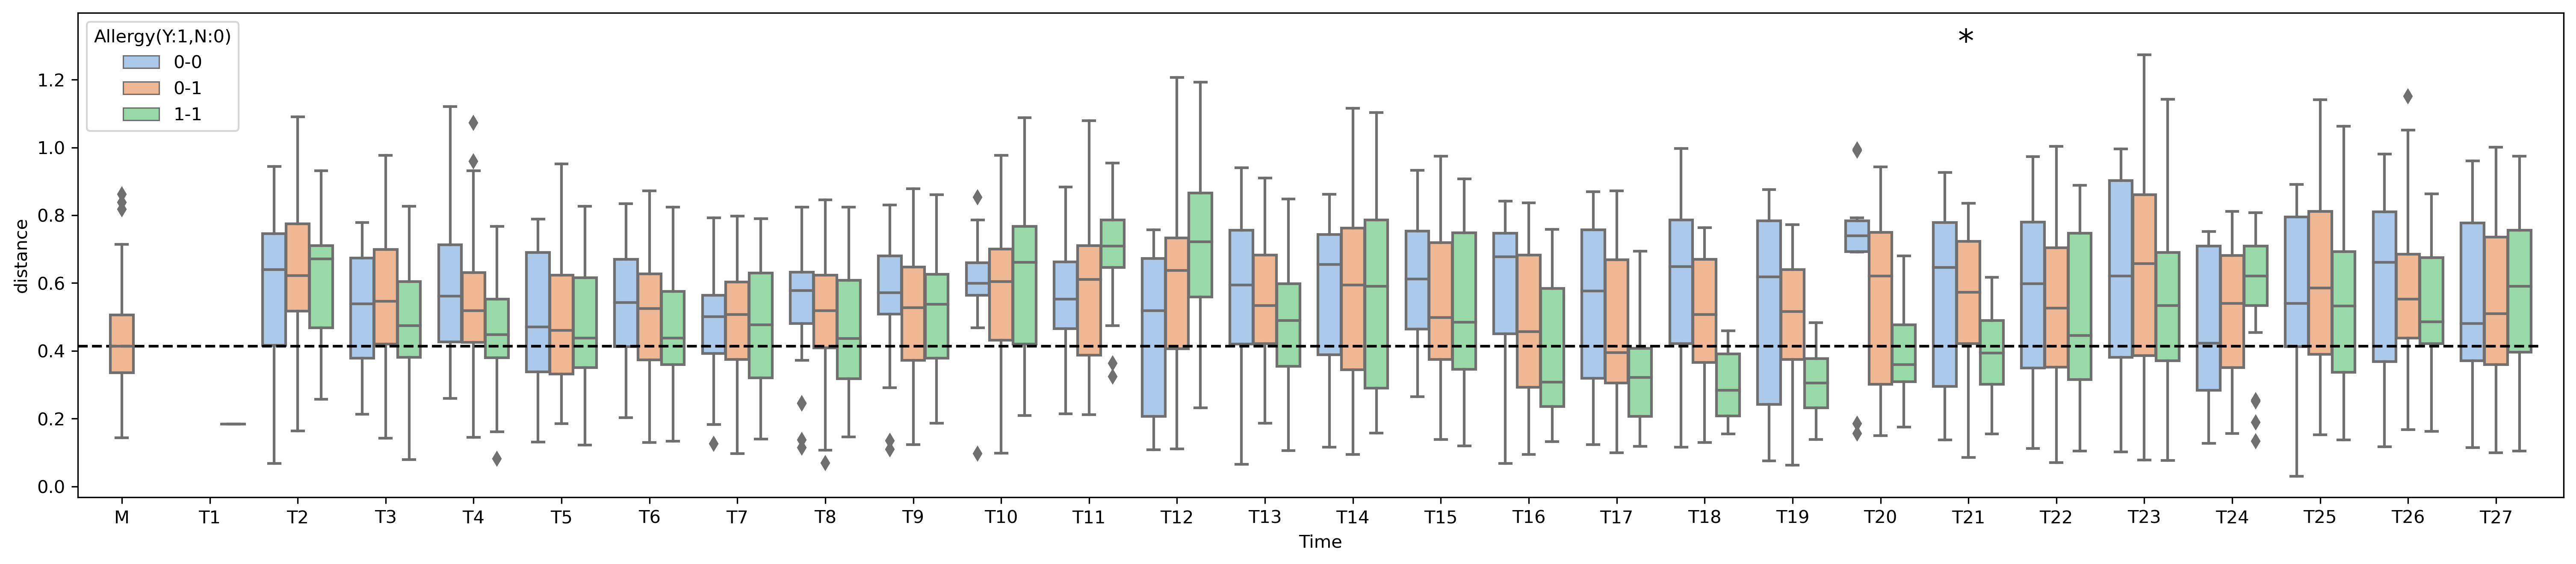

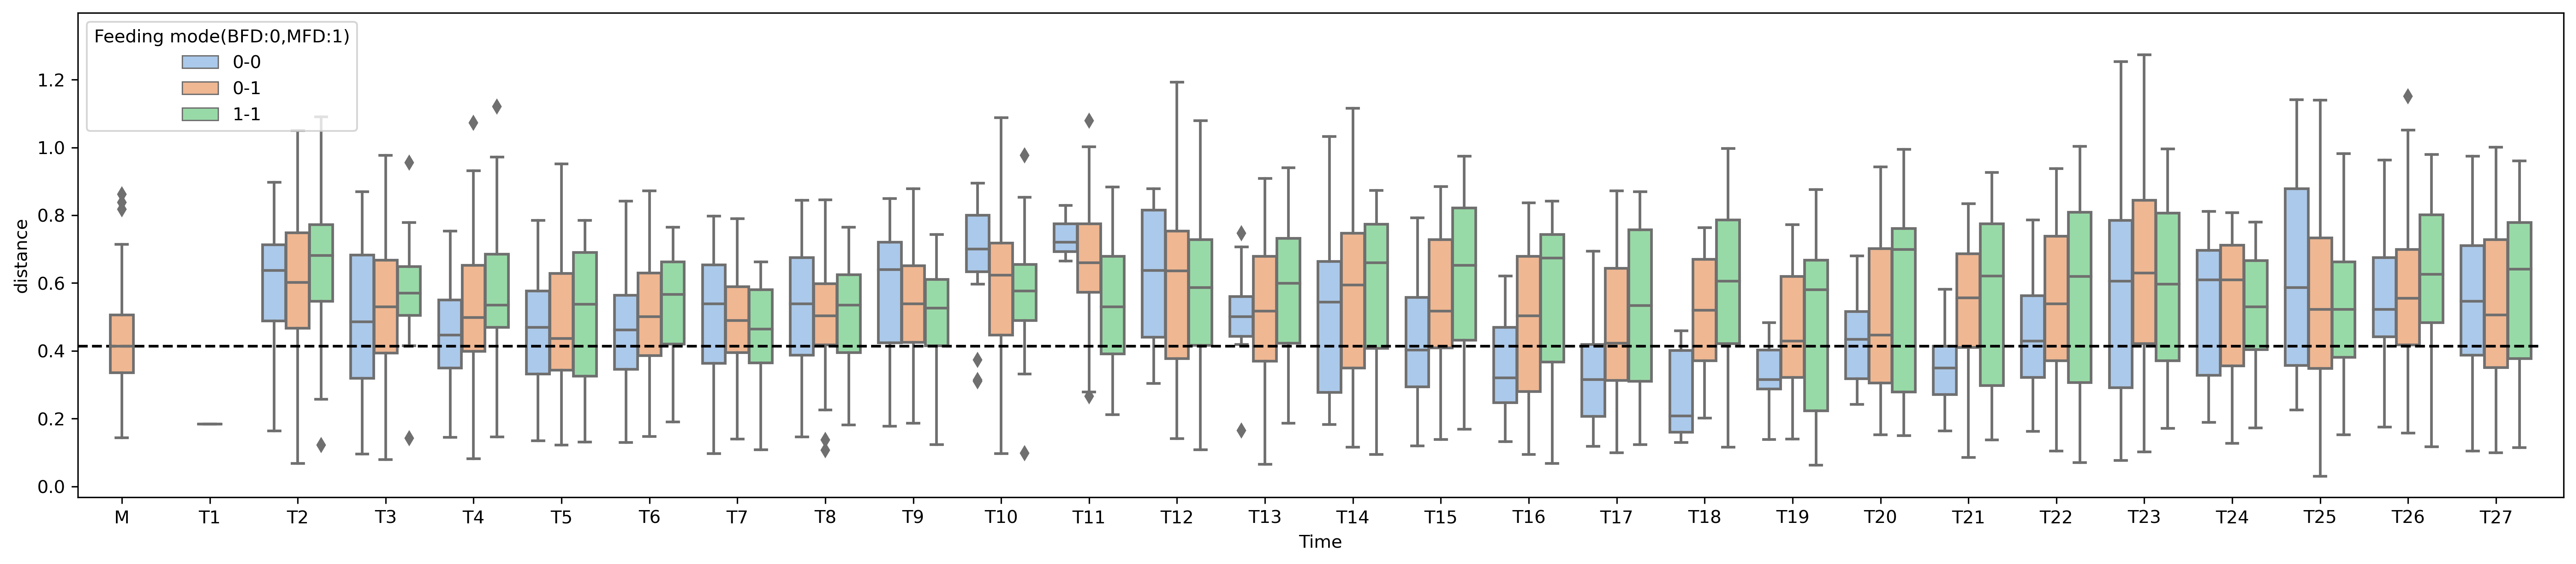

In [5]:
distance_matrix = pd.read_csv('../Results/1.3. Beta_weighted_unifrac_matrix.csv', index_col=0)
fig = beta_group_compare(meta, distance_matrix, 'Gender', ['M-M', 'F-M', 'F-F'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_Gender.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Mode of delivery', ['C-C', 'C-V', 'V-V'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_delivery.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Solid food', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_SolidFood.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Breastfeeding', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_Breastfeeding.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Sibling(Y:1,N:0)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_Sibling.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'PAE(Y:1,N:0)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_PAE.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Allergy(Y:1,N:0)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_Allergy.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Feeding mode(BFD:0,MFD:1)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_weighted_unifrac_Feedingmode.pdf', dpi=300)

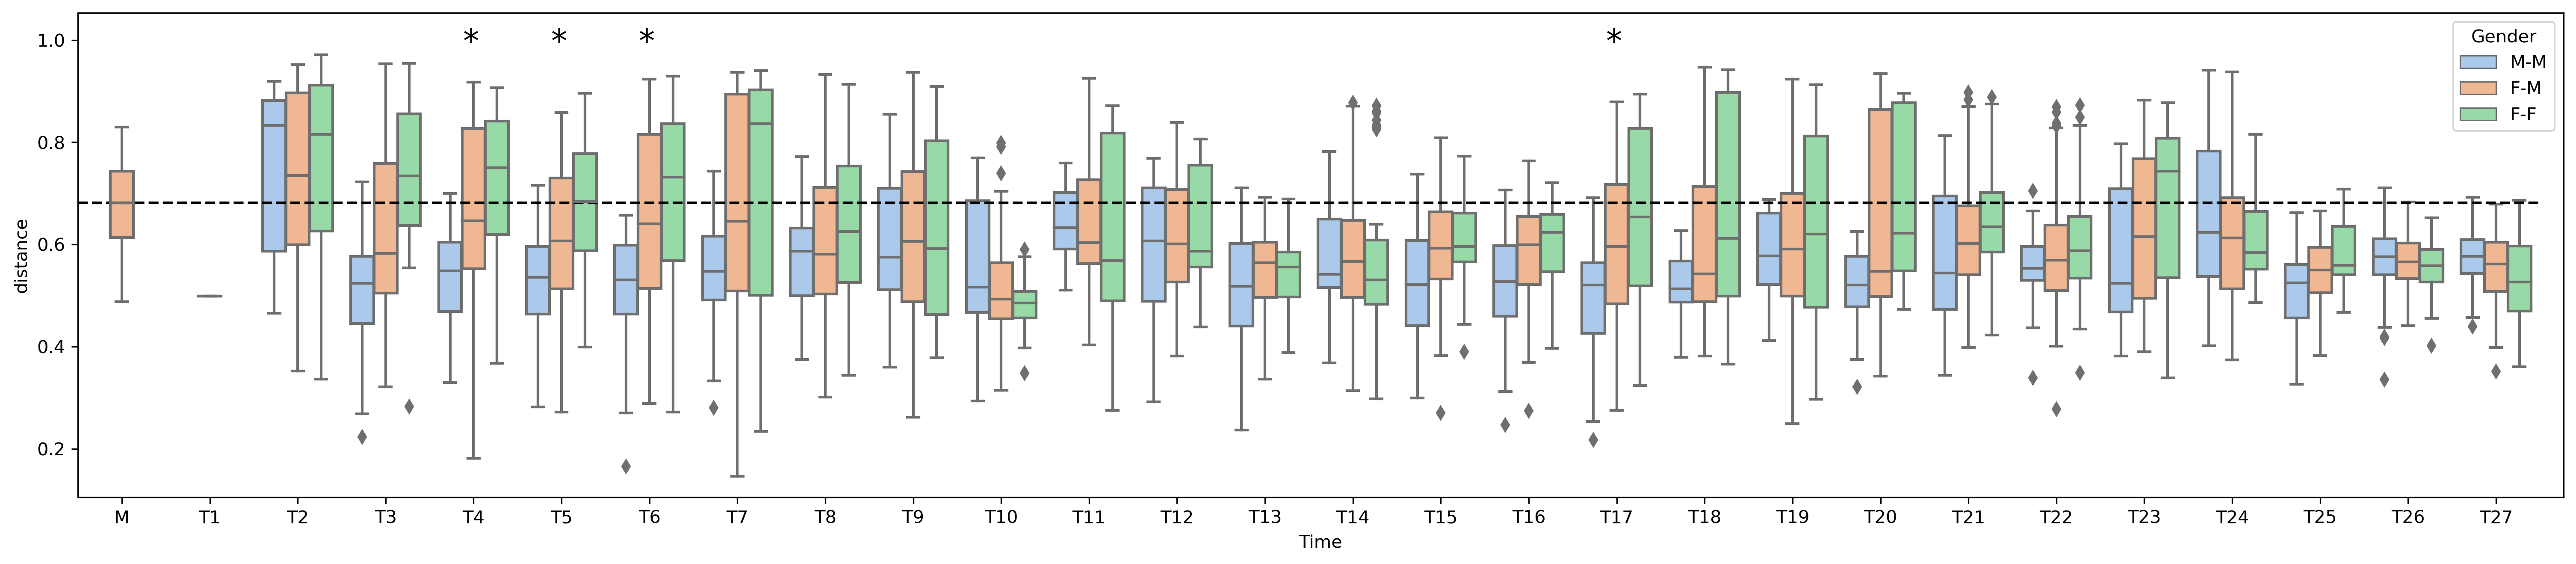

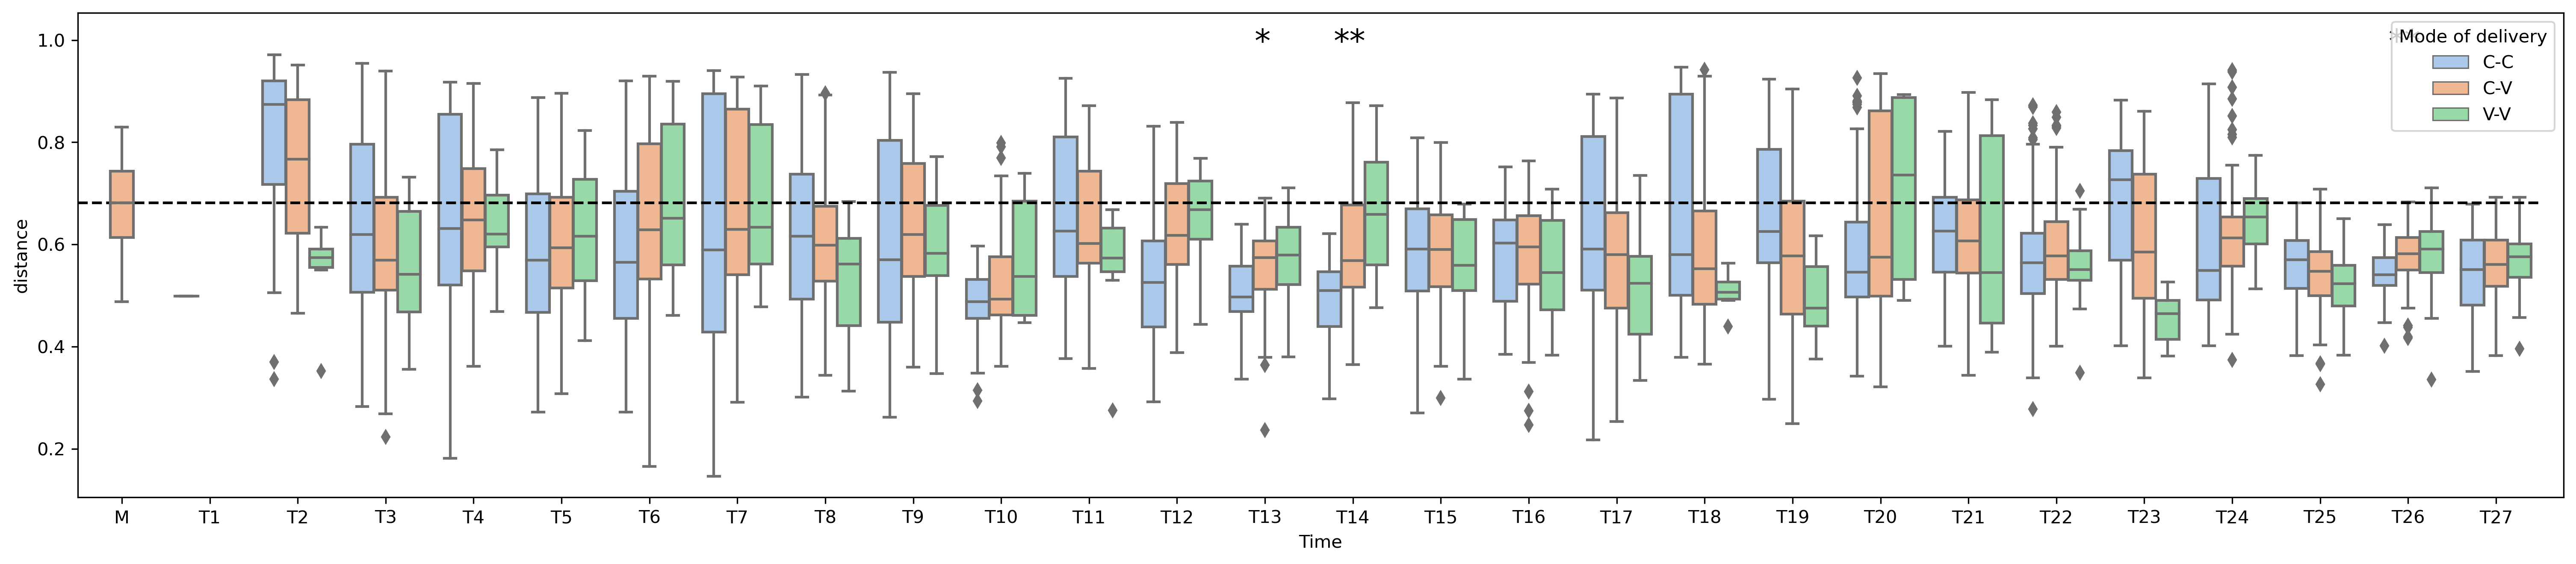

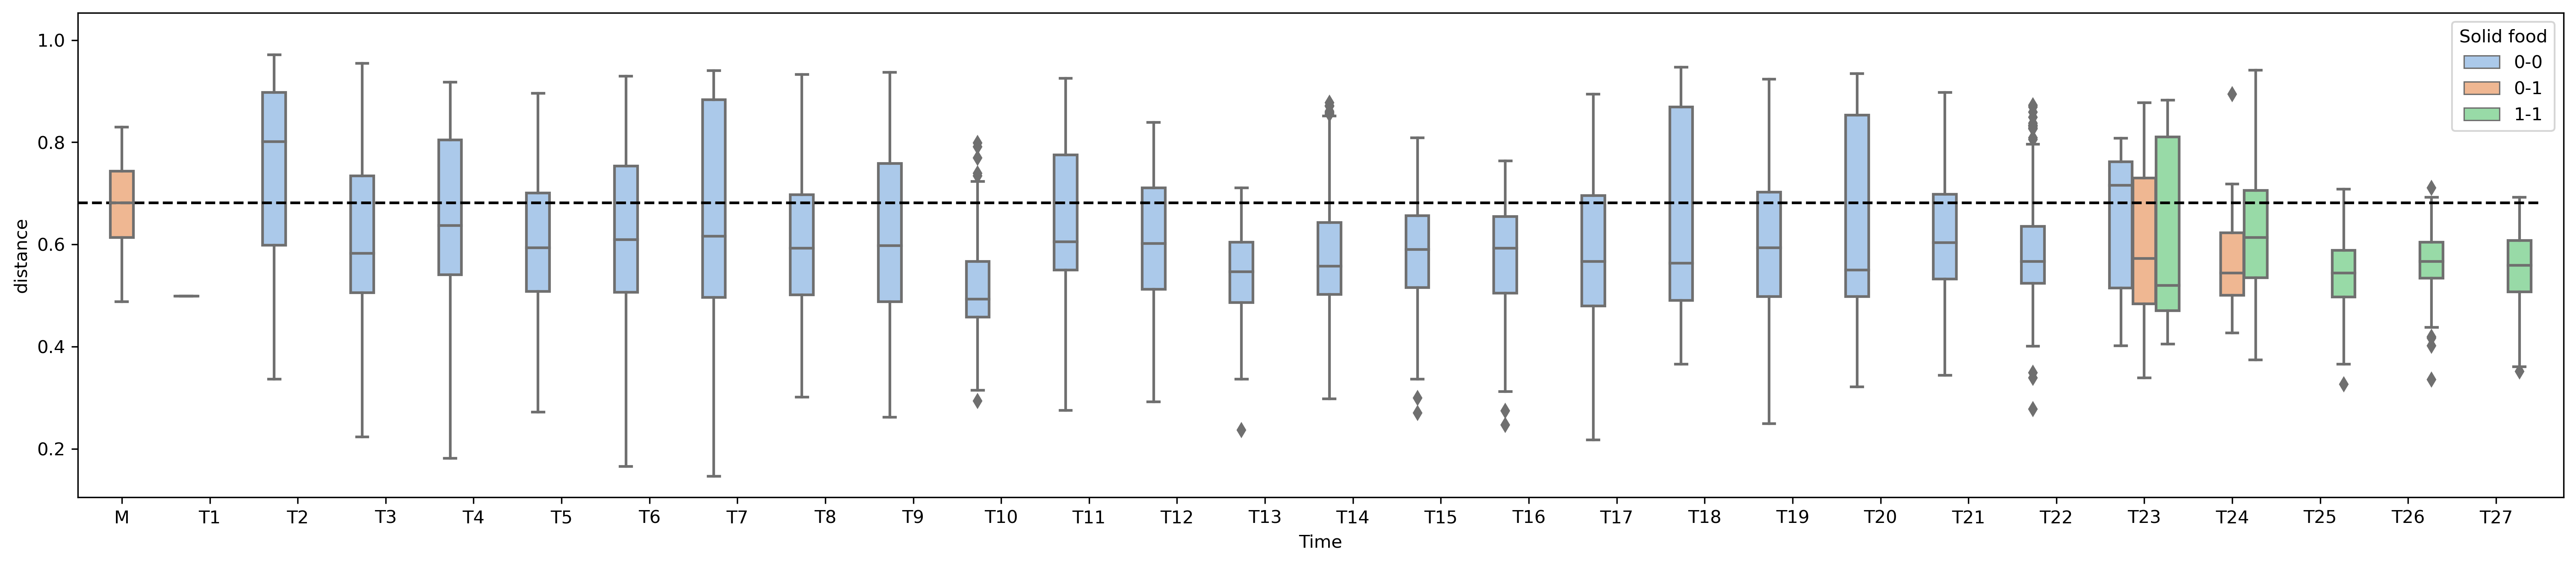

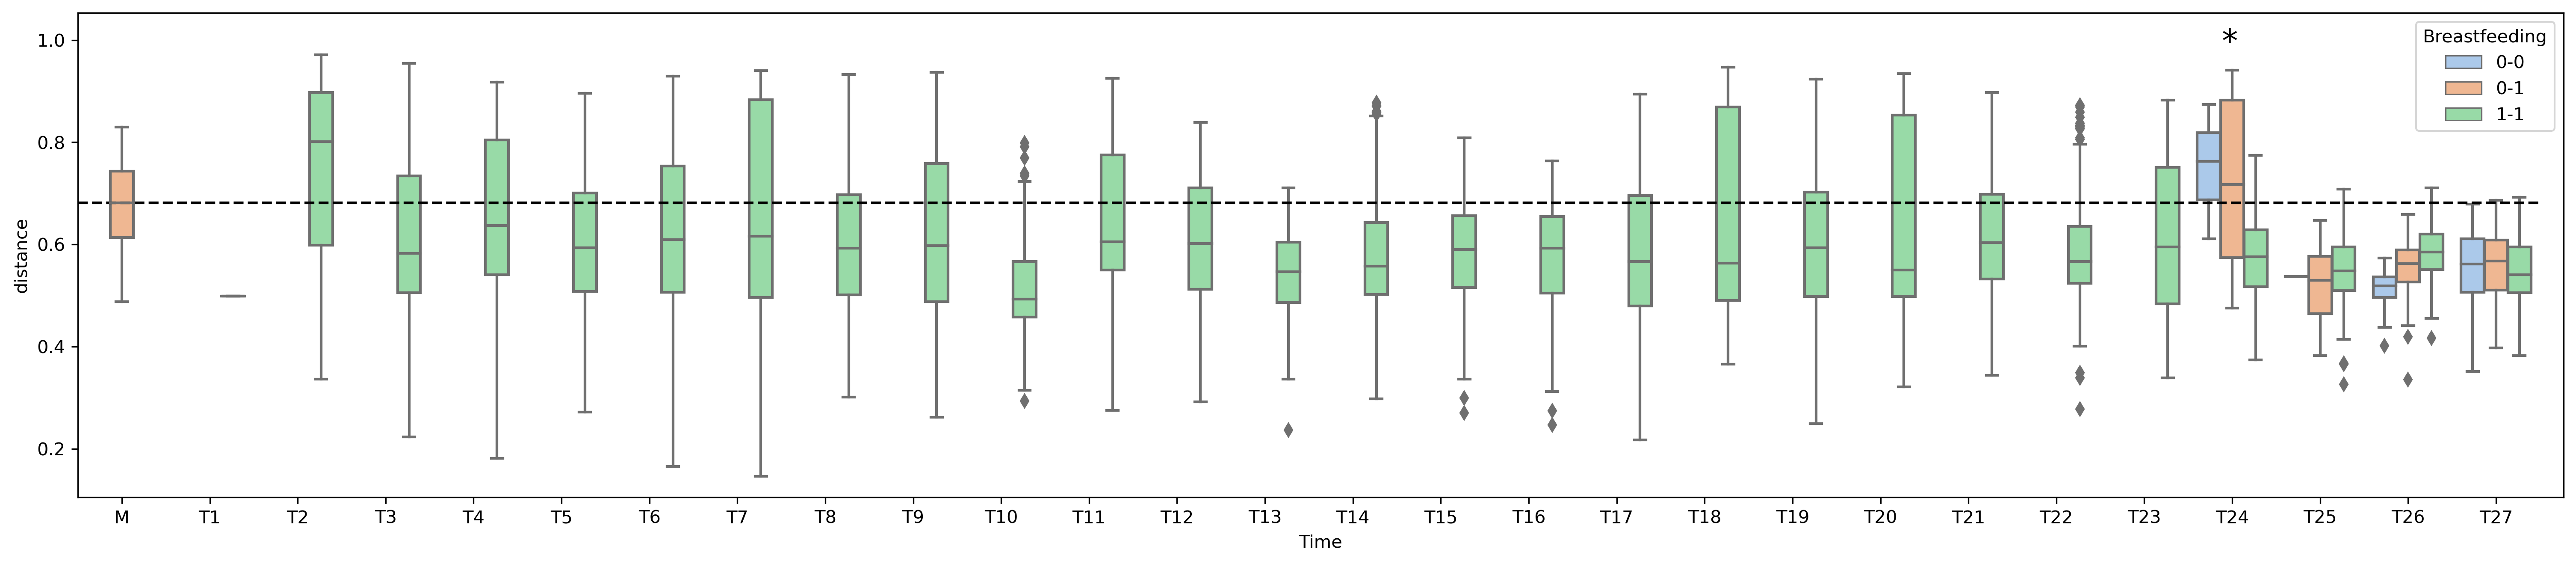

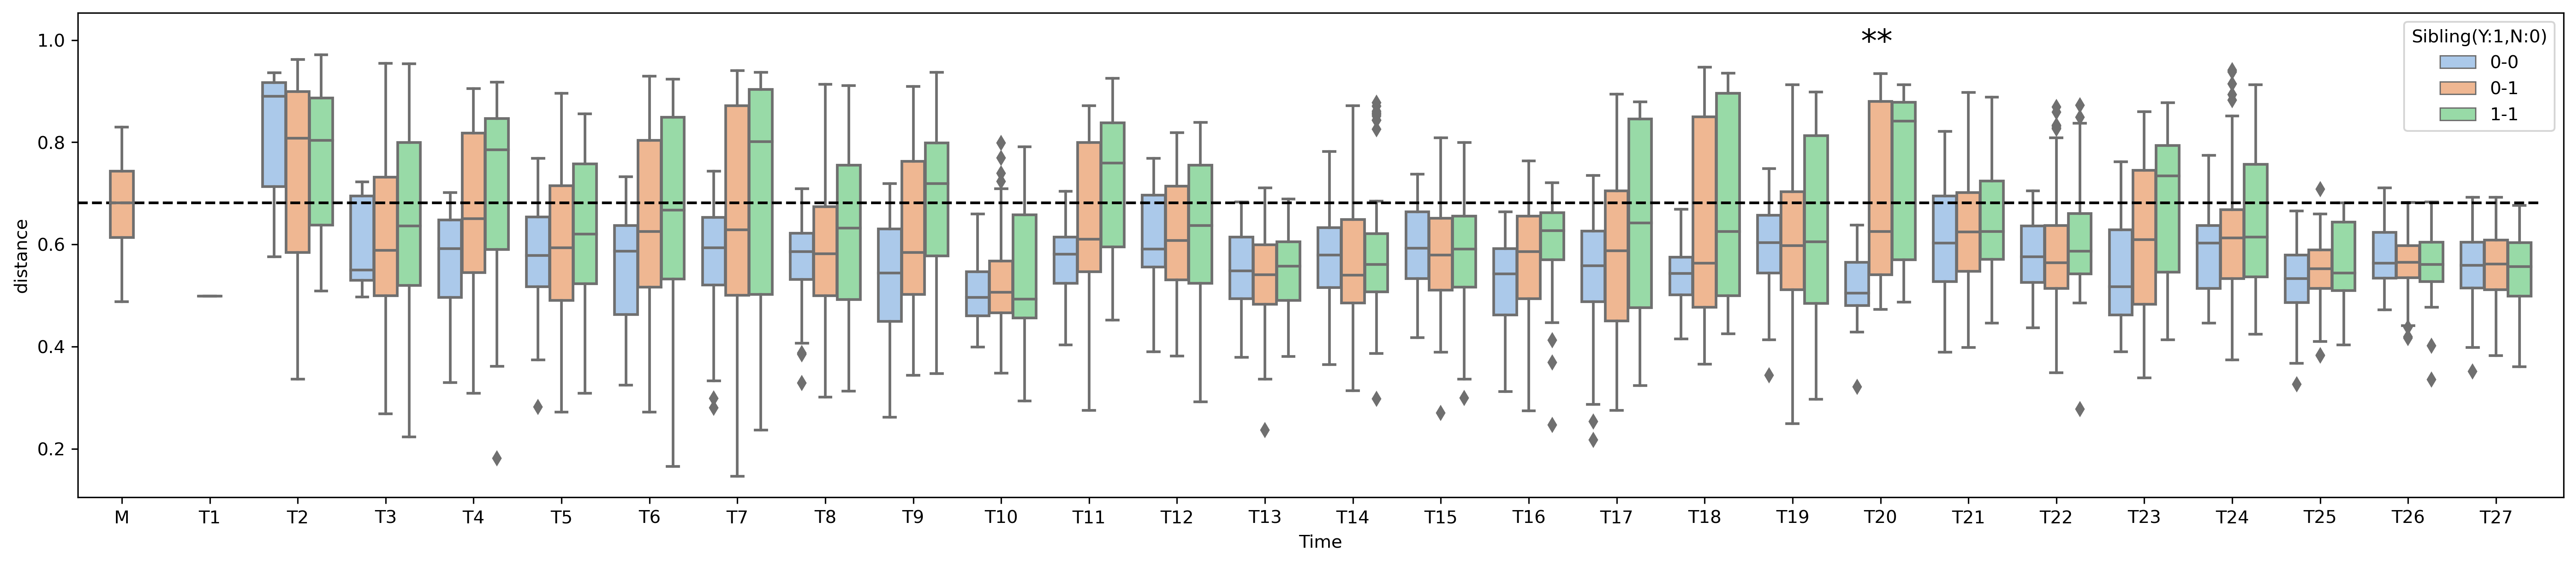

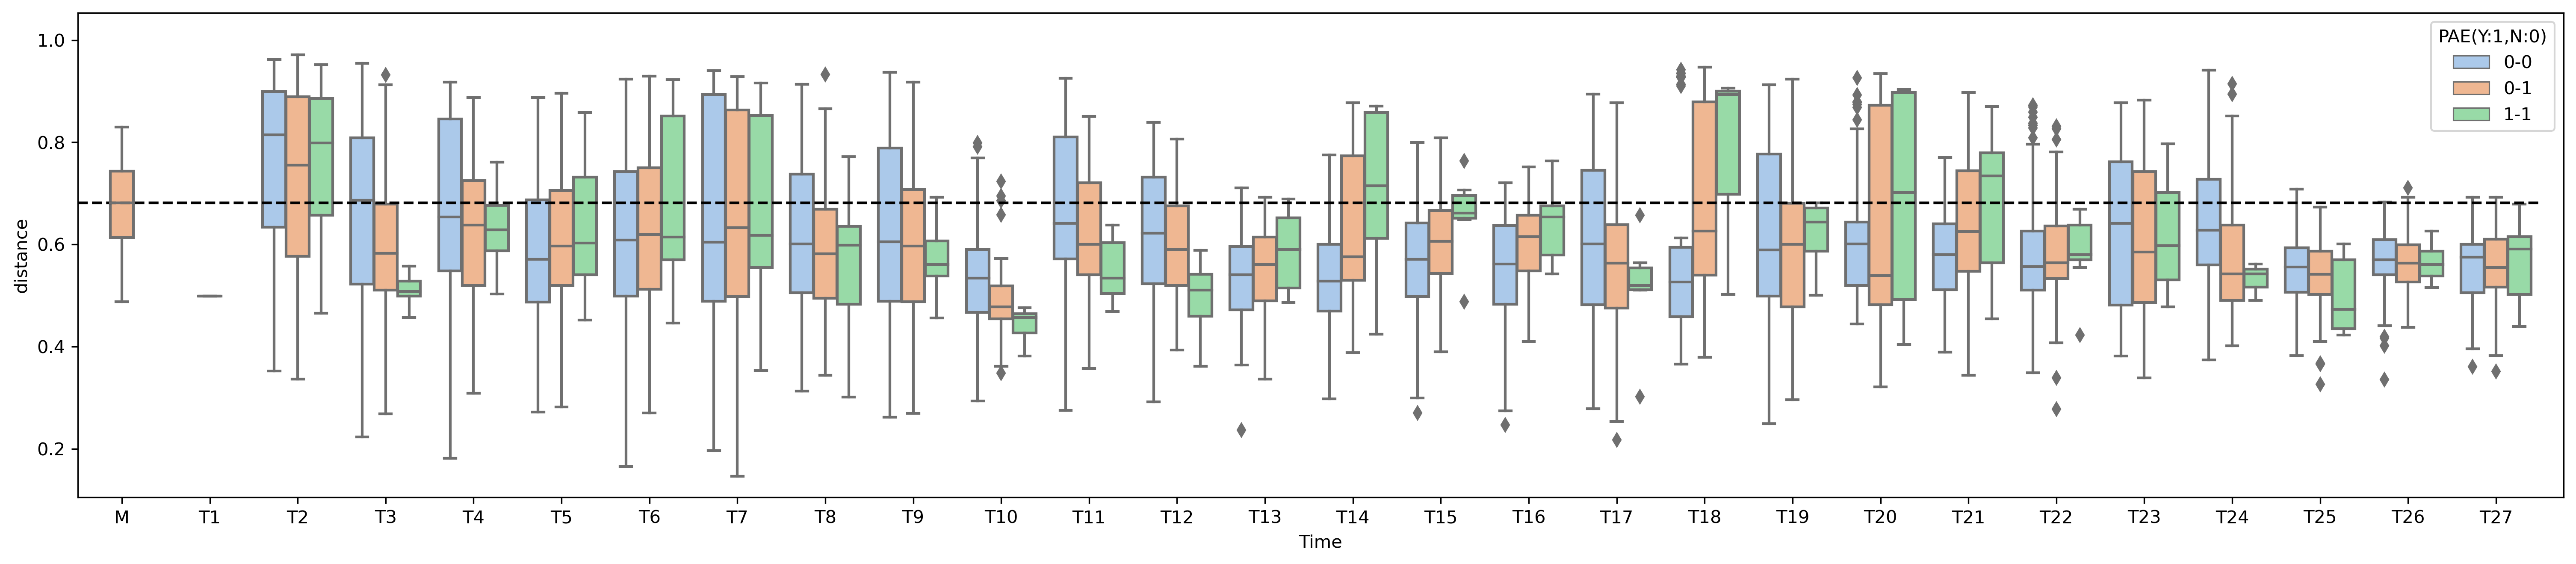

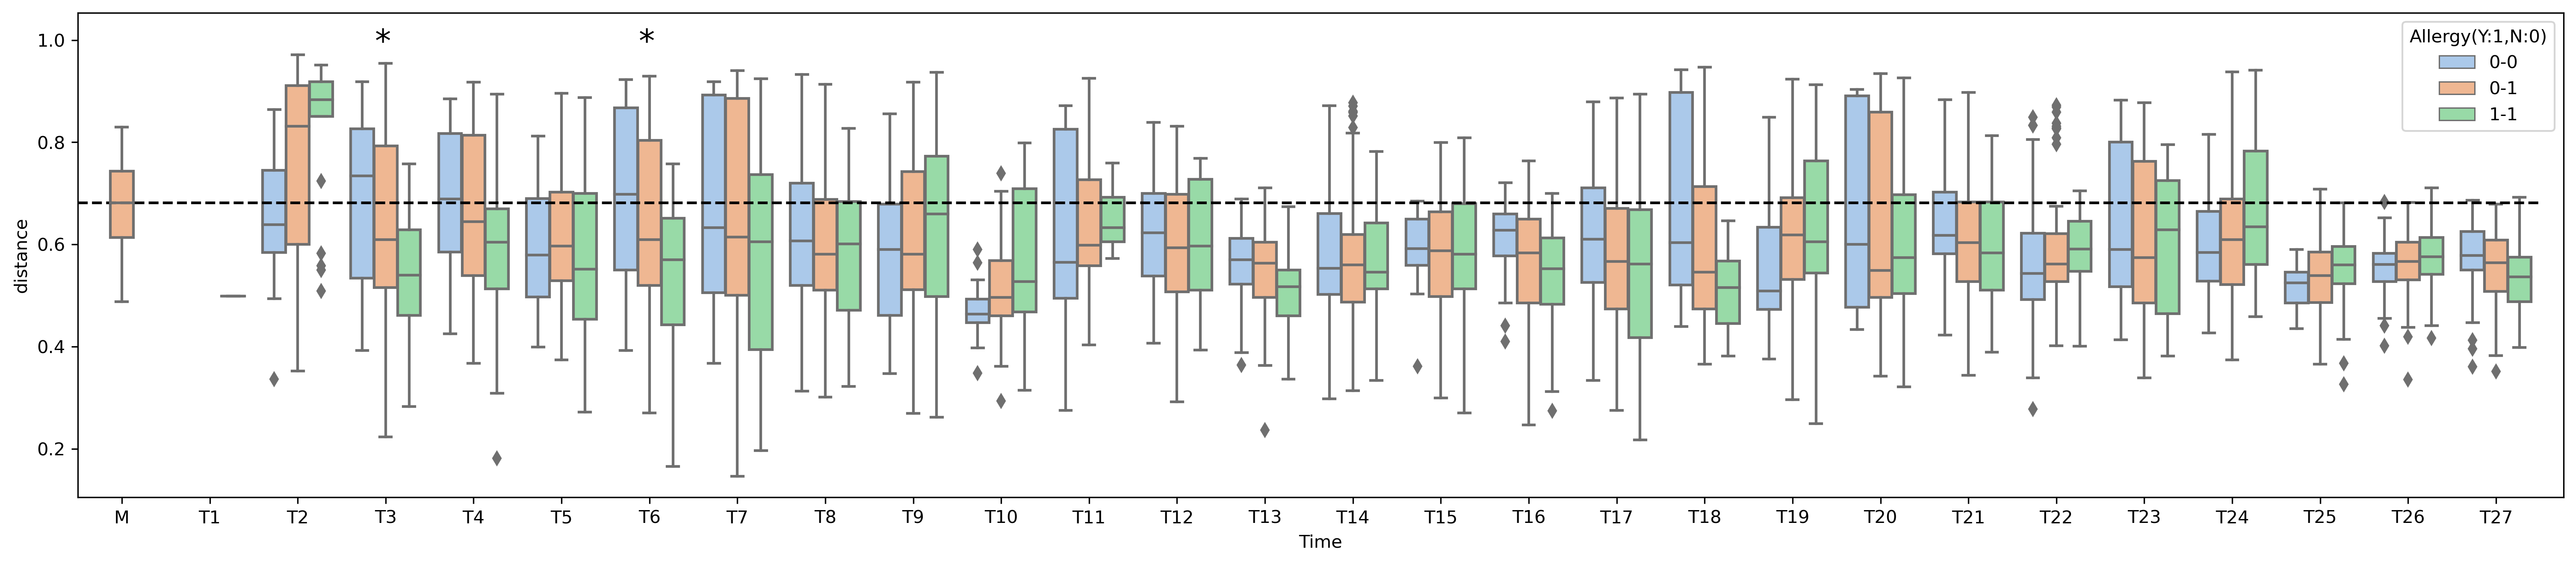

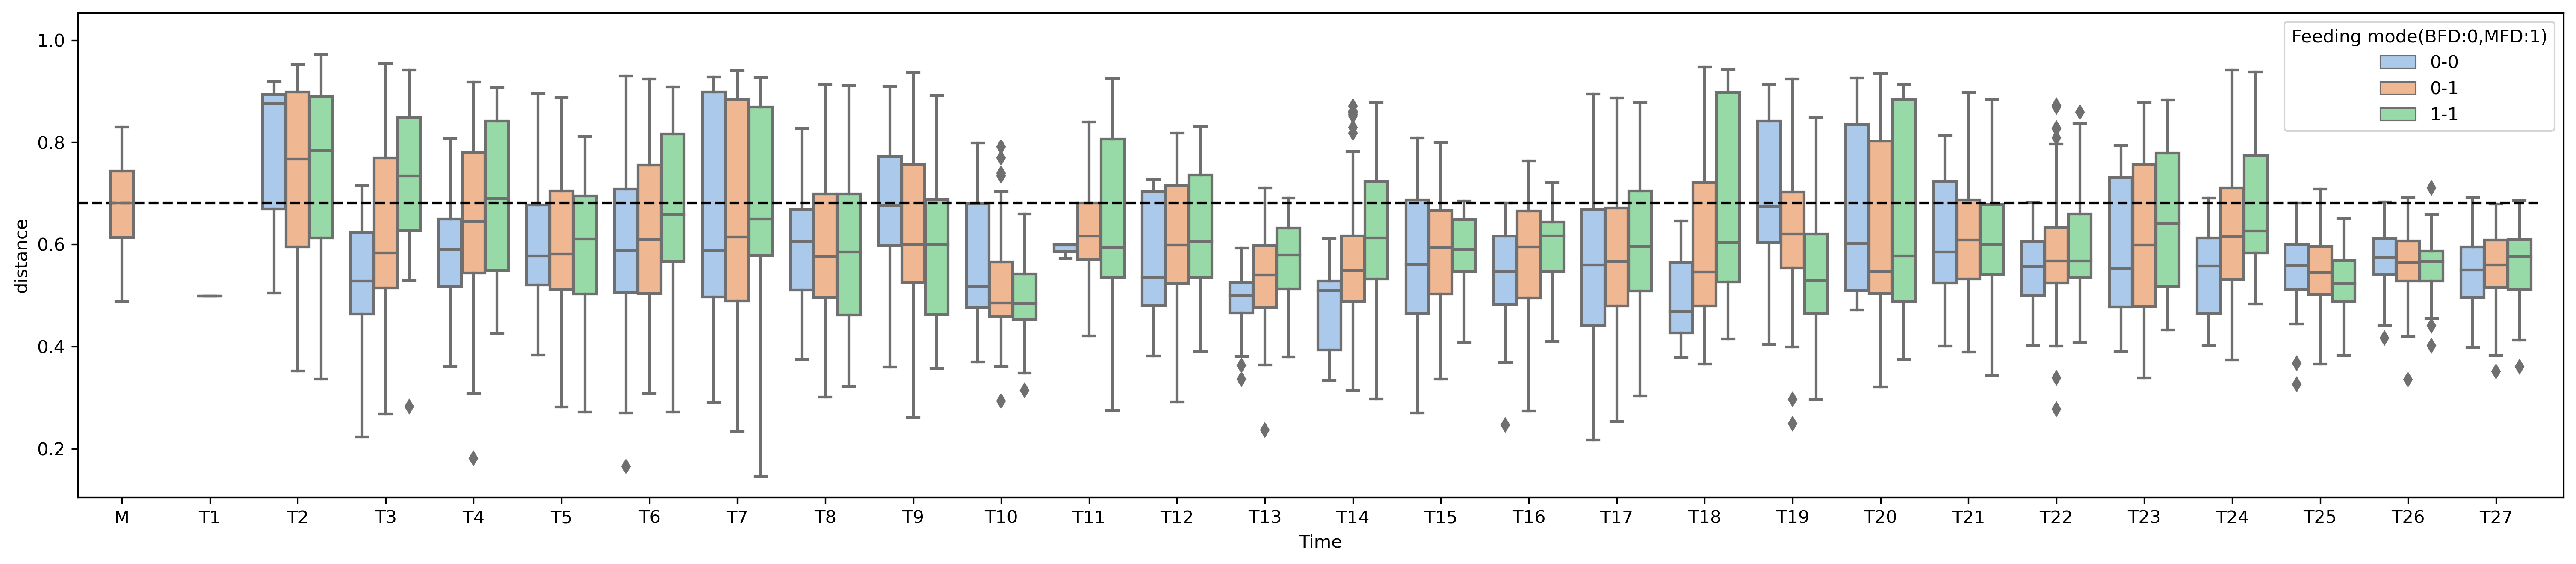

In [6]:
distance_matrix = pd.read_csv('../Results/1.3. Beta_unweighted_unifrac_matrix.csv', index_col=0)
fig = beta_group_compare(meta, distance_matrix, 'Gender', ['M-M', 'F-M', 'F-F'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_Gender.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Mode of delivery', ['C-C', 'C-V', 'V-V'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_delivery.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Solid food', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_SolidFood.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Breastfeeding', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_Breastfeeding.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Sibling(Y:1,N:0)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_Sibling.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'PAE(Y:1,N:0)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_PAE.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Allergy(Y:1,N:0)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_Allergy.pdf', dpi=300)

fig = beta_group_compare(meta, distance_matrix, 'Feeding mode(BFD:0,MFD:1)', ['0-0', '0-1', '1-1'])
fig.savefig('../Results_0609/3.3. Beta多样性_unweighted_unifrac_Feedingmode.pdf', dpi=300)

In [32]:
pdata

t Group  distance
0     1    T2  0.734857
1     2    T3  0.754518
2     3    T4  0.820815
3     4    T5  0.679622
4     5    T6  0.819304
..   ..   ...       ...
359  22   T23  0.841092
360  23   T24  0.832498
361  24   T25  0.816930
362  25   T26  0.812026
363  26   T27  0.817299

[364 rows x 3 columns]

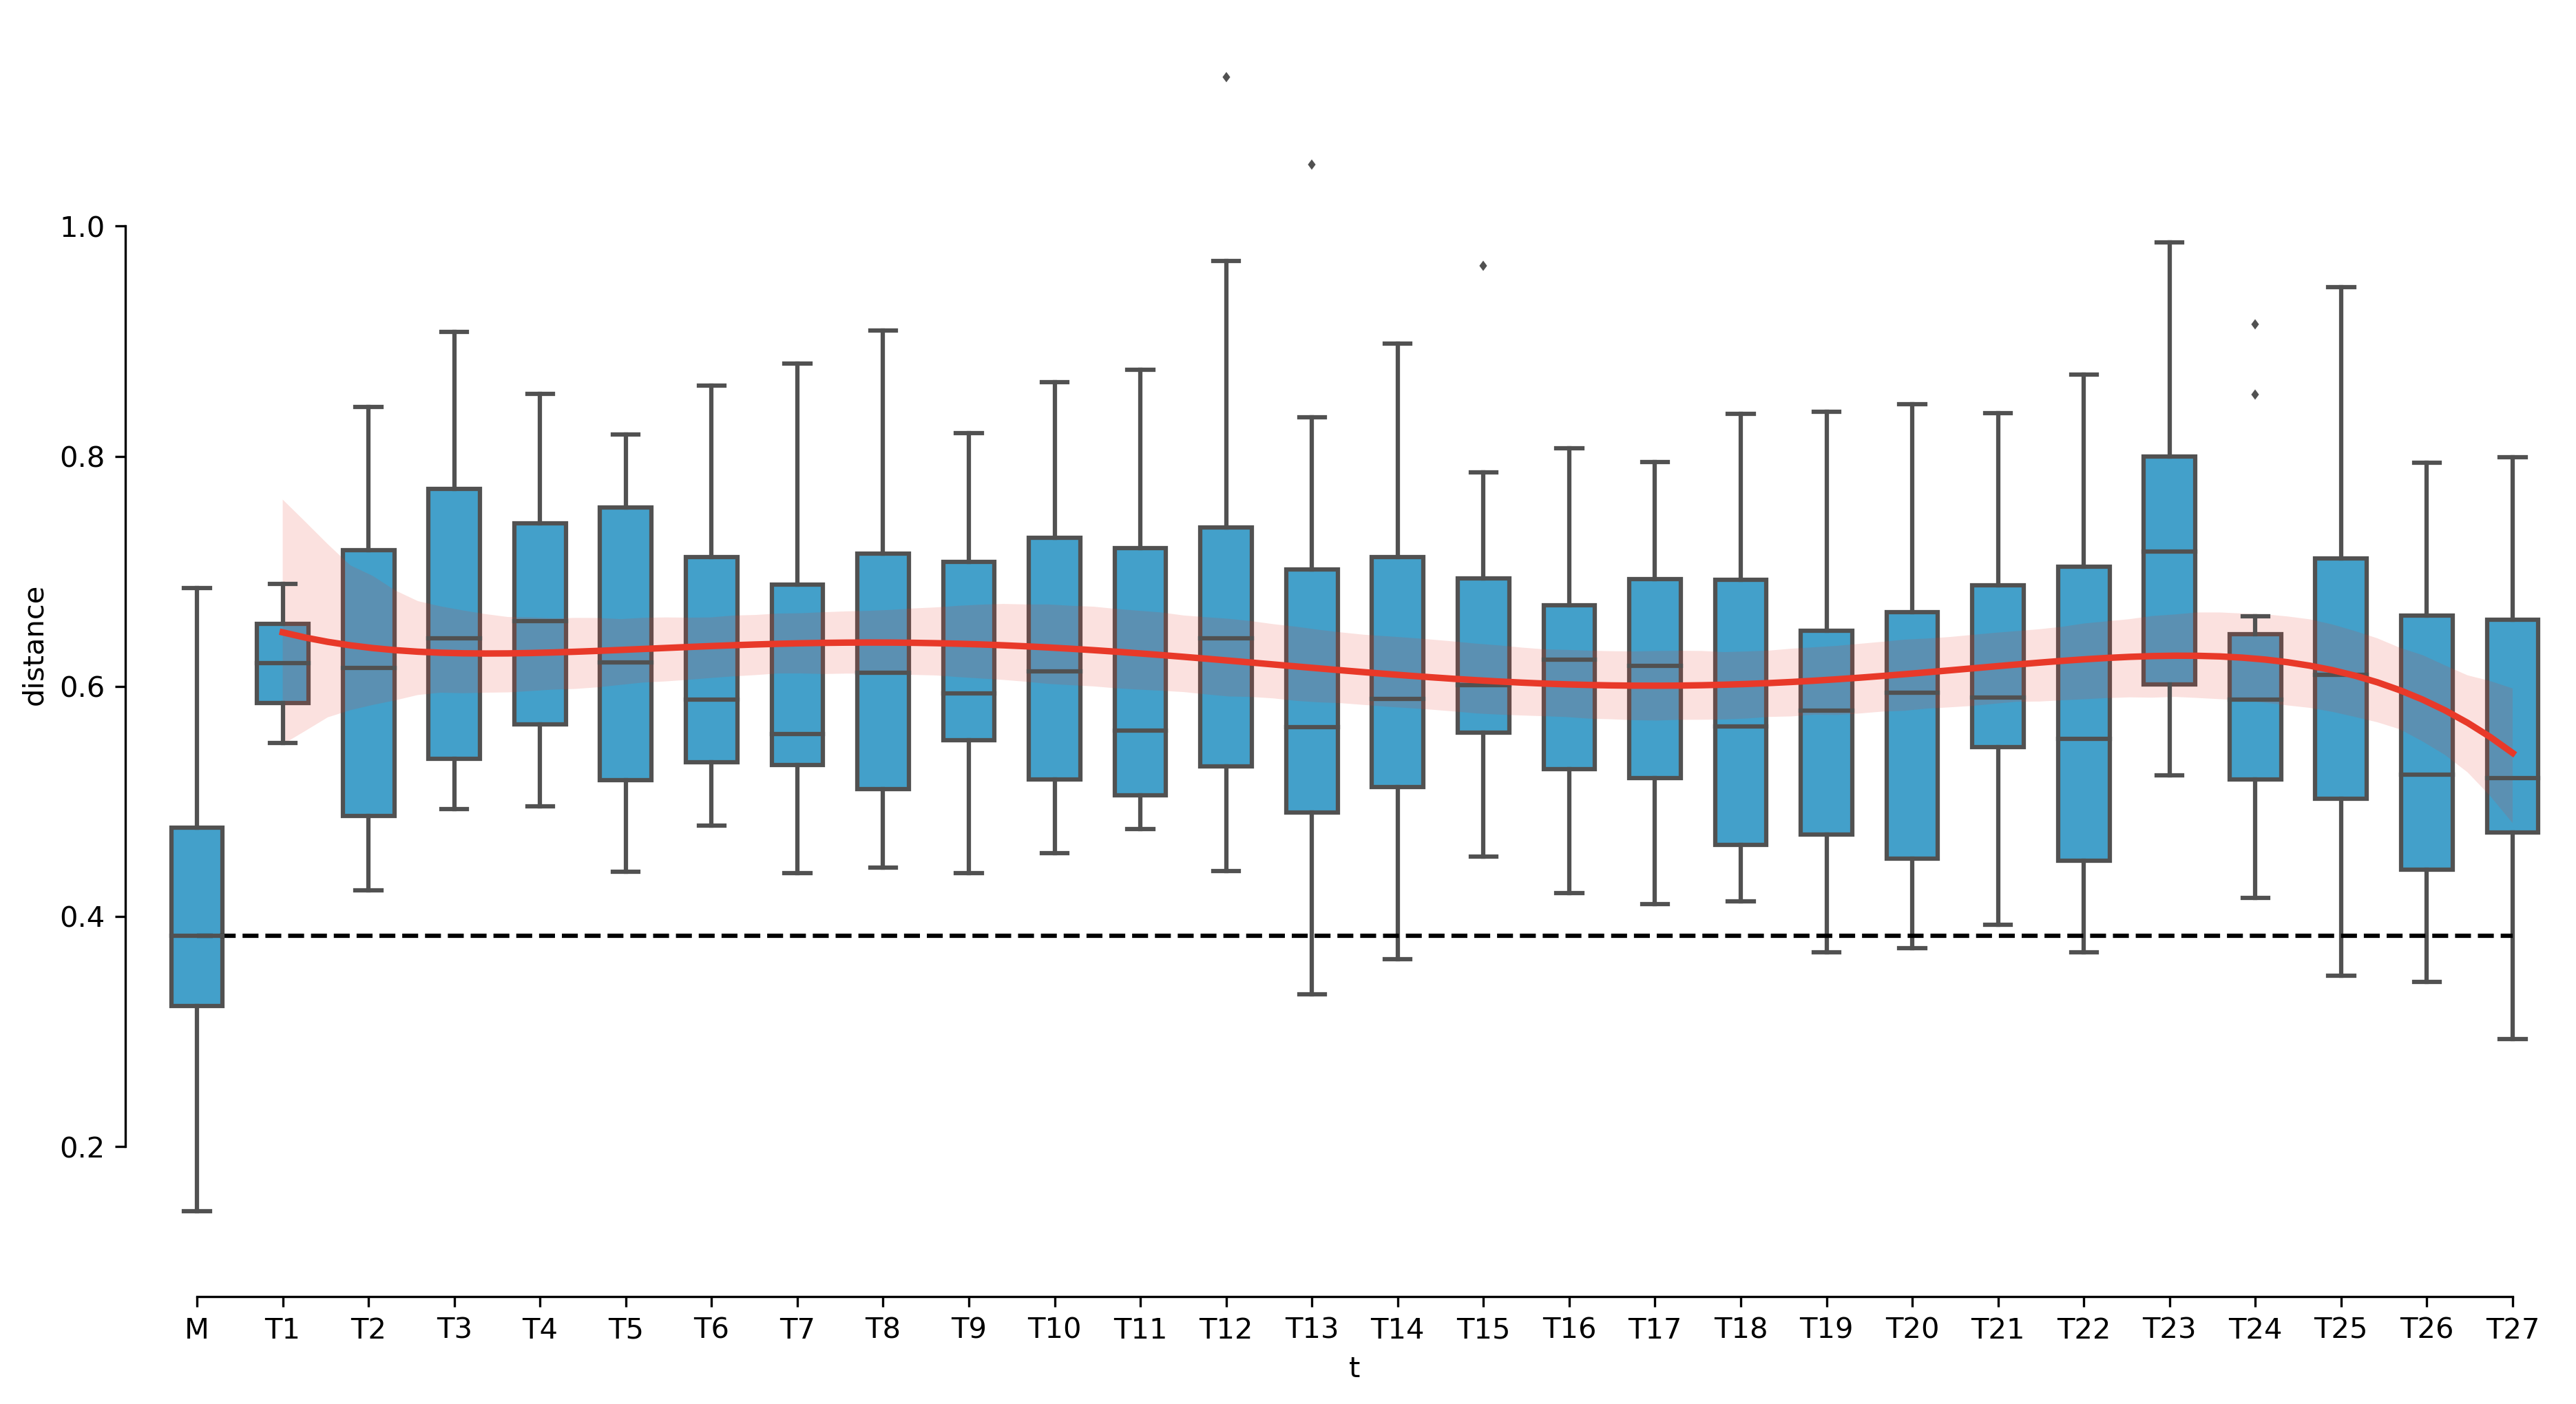

In [43]:
distance_matrix = pd.read_csv('../Results/1.3. Beta_weighted_unifrac_matrix.csv', index_col=0)
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
pdata = []
for c in Childs:
    links = family_links[str(c)]
    if links[0][0]=='M':
        for sample in links[1:]:
            t = 'T'+sample.split('_')[-1]
            dis = distance_matrix.loc[links[0], sample]
            pdata.append([int(sample.split('_')[-1]), t, dis])

mothers = meta.loc[meta['Sample_type']=='M', :].index
for i in range(len(mothers)-1):
    for j in range(i+1, len(mothers)):
        dis = distance_matrix.loc[mothers[i], mothers[j]]
        pdata.append([0, 'M', dis])
pdata = pd.DataFrame(pdata, columns=['t', 'Group', 'distance'])

fig = plt.figure(figsize=(15, 8), dpi=300)
ax = sns.boxplot(x="Group", y="distance", data=pdata, order=Times, fliersize=1.5, color='#2ca9e1', width=0.6)
ax = sns.regplot(x="t", y="distance", data=pdata.loc[pdata['Group']!='M', :], order=5, ci=95, scatter=False, 
                 n_boot=1000, color='#e83929', line_kws={'zorder':9})
_ = plt.hlines(y=pdata.loc[pdata['Group']=='M', 'distance'].median(), xmin=0., xmax=27., color='k', ls='--')
_ = sns.despine(offset=10, trim=True)
fig.savefig('../Results_0609/3.3. Beta多样性与母亲比较_weighted_unifrac.pdf', dpi=300)

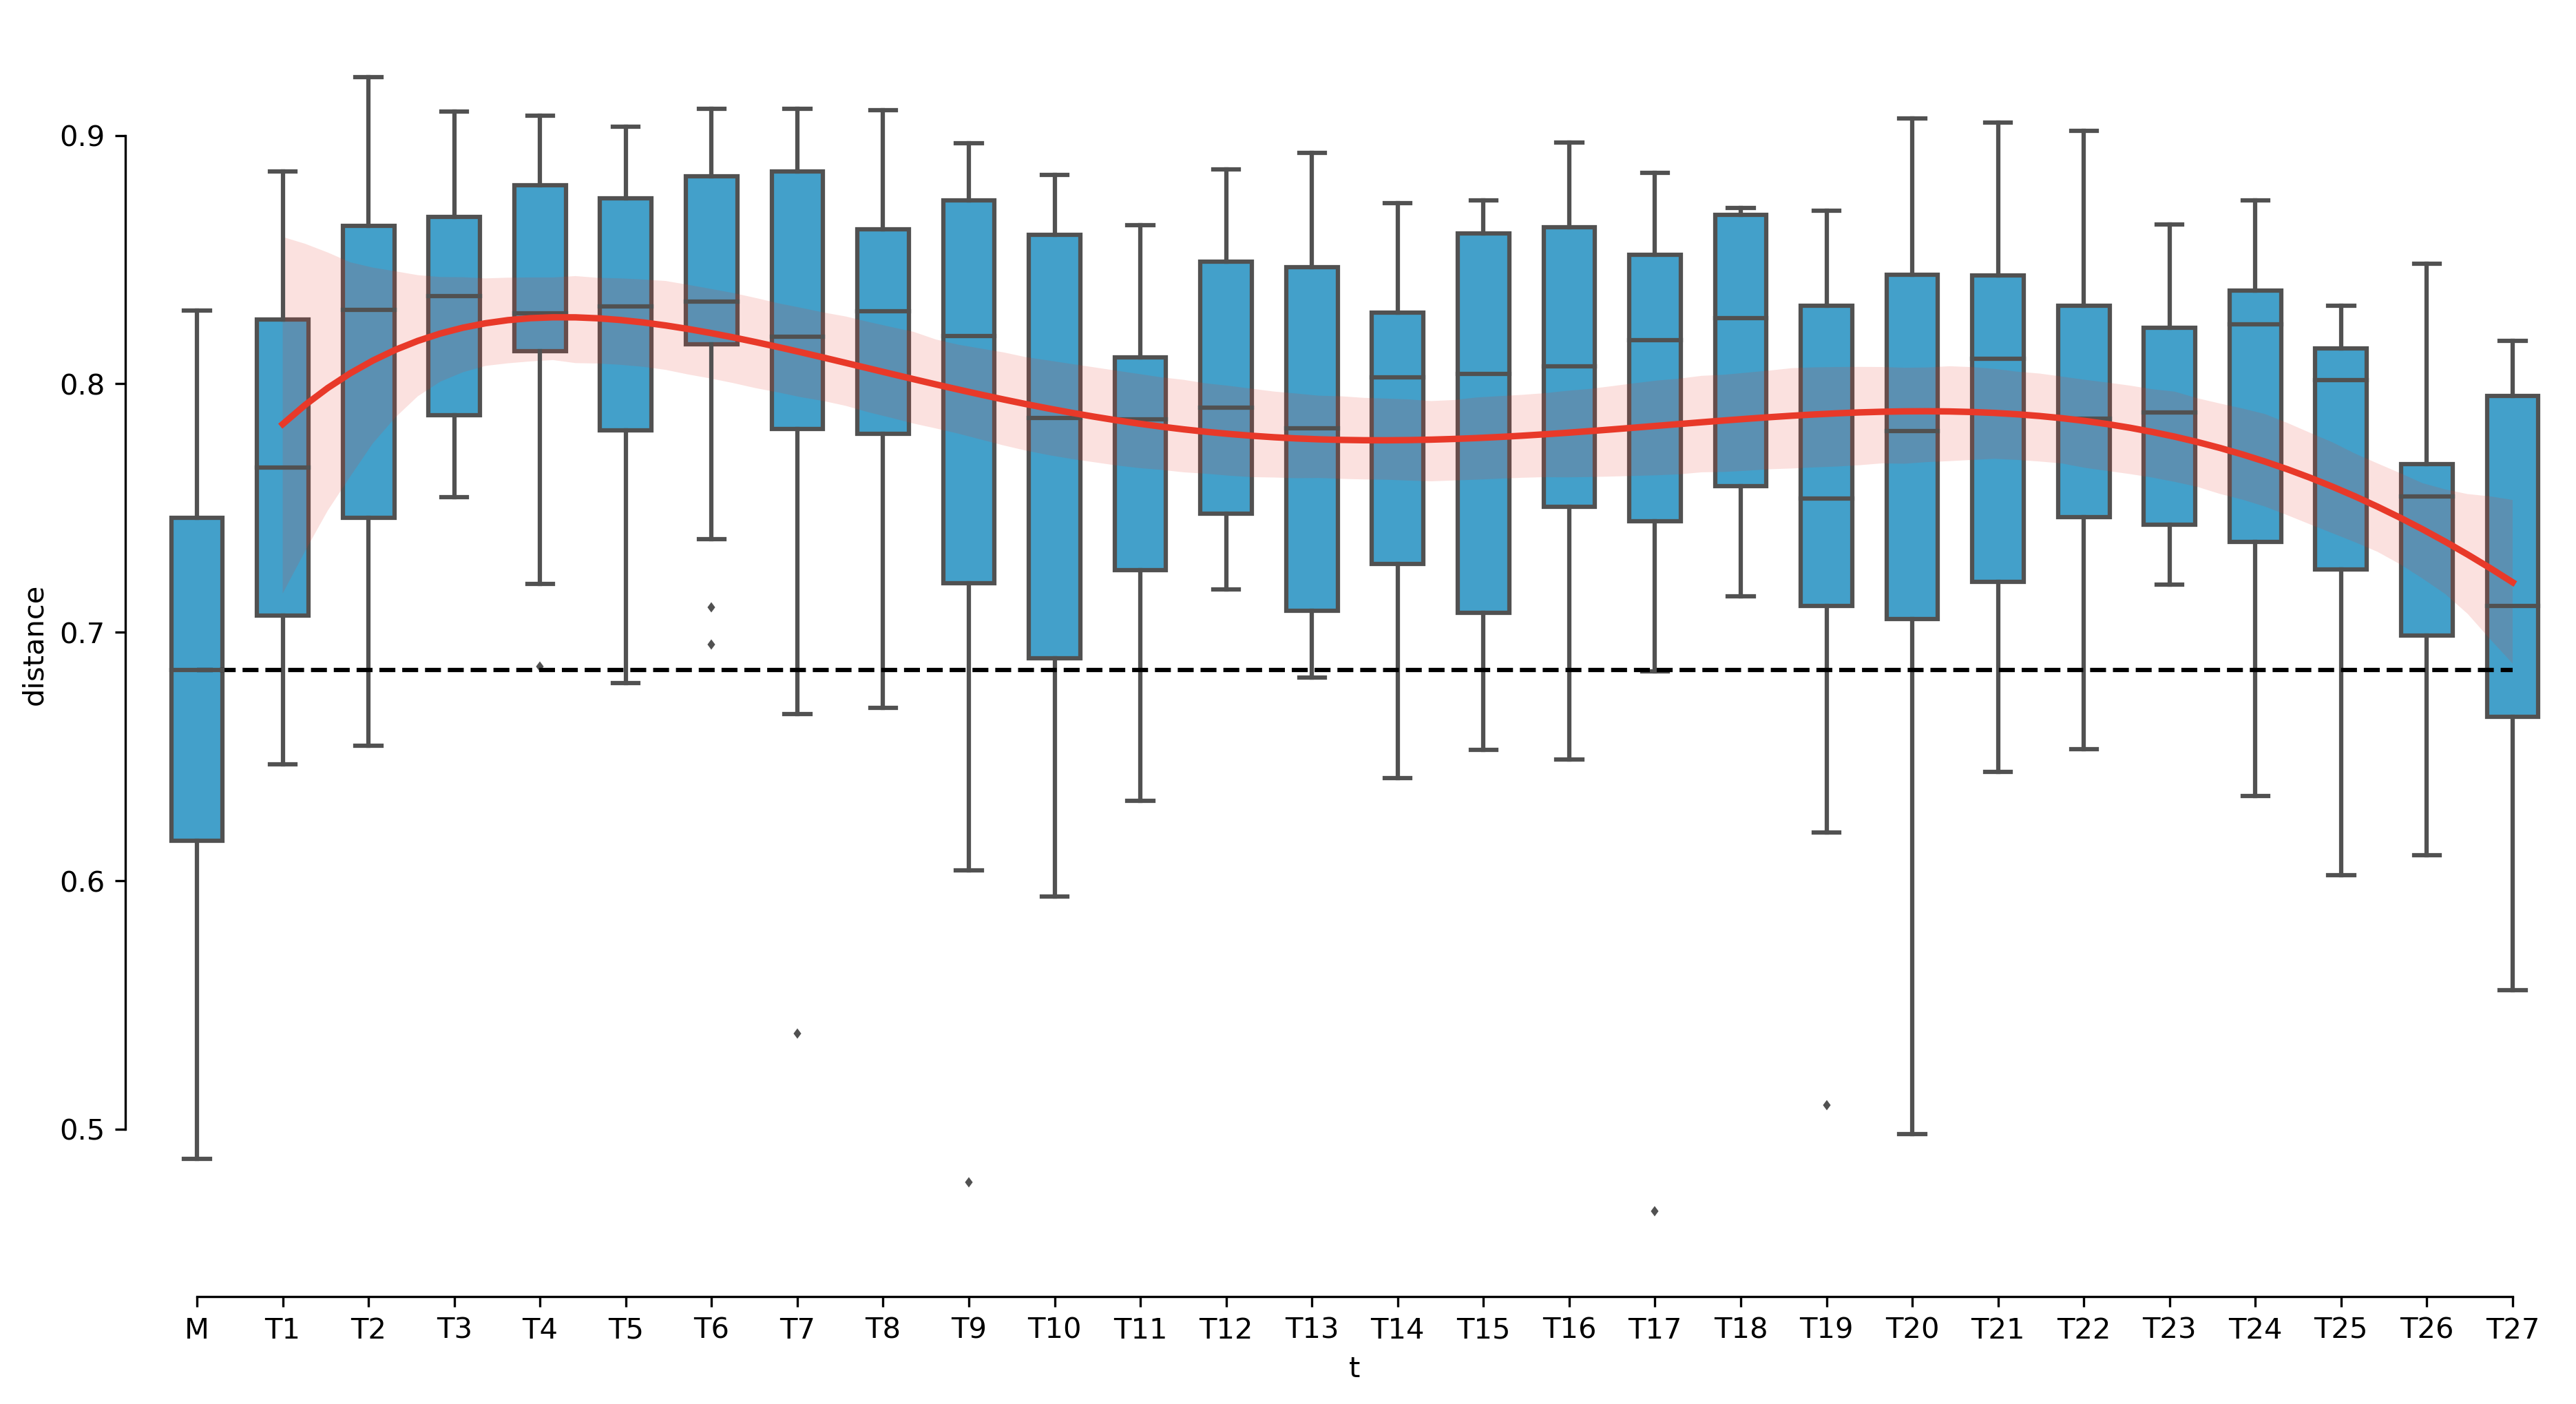

In [44]:
distance_matrix = pd.read_csv('../Results/1.3. Beta_unweighted_unifrac_matrix.csv', index_col=0)
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
pdata = []
for c in Childs:
    links = family_links[str(c)]
    if links[0][0]=='M':
        for sample in links[1:]:
            t = 'T'+sample.split('_')[-1]
            dis = distance_matrix.loc[links[0], sample]
            pdata.append([int(sample.split('_')[-1]), t, dis])

mothers = meta.loc[meta['Sample_type']=='M', :].index
for i in range(len(mothers)-1):
    for j in range(i+1, len(mothers)):
        dis = distance_matrix.loc[mothers[i], mothers[j]]
        pdata.append([0, 'M', dis])
pdata = pd.DataFrame(pdata, columns=['t', 'Group', 'distance'])

fig = plt.figure(figsize=(15, 8), dpi=300)
ax = sns.boxplot(x="Group", y="distance", data=pdata, order=Times, fliersize=1.5, color='#2ca9e1', width=0.6)
ax = sns.regplot(x="t", y="distance", data=pdata.loc[pdata['Group']!='M', :], order=5, ci=95, scatter=False, 
                 n_boot=1000, color='#e83929', line_kws={'zorder':9})
_ = plt.hlines(y=pdata.loc[pdata['Group']=='M', 'distance'].median(), xmin=0., xmax=27., color='k', ls='--')
_ = sns.despine(offset=10, trim=True)
fig.savefig('../Results_0609/3.3. Beta多样性与母亲比较_unweighted_unifrac.pdf', dpi=300)